<a href="https://colab.research.google.com/github/mnowatzki/DUNEMINDS/blob/main/duneminds_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**INTRO**

In [ ]:
#@title installations

# System deps for geospatial libs (helps pip install rasterio / GDAL-based packages)
!apt-get update -qq
!apt-get install -y -qq libgdal-dev gdal-bin

# Upgrade pip
!pip install --upgrade pip --quiet

# TensorFlow (Colab usually already has a compatible TF; we install latest stable)
!pip install --upgrade tensorflow --quiet

# Provide classic Keras preprocessing (ImageDataGenerator) as a separate package
!pip install --upgrade keras_preprocessing --quiet

# Core scientific stack
!pip install --upgrade numpy pandas matplotlib seaborn tqdm scikit-image scikit-learn pillow openpyxl --quiet

# Geospatial libraries (rasterio, geopandas, pyproj, folium, shapely, fiona)
!pip install --upgrade rasterio geopandas folium pyproj shapely fiona --quiet

# Small extras you used
!pip install --upgrade tqdm openpyxl --quiet

# Print versions to help debugging (will show after restart too)
import sys, importlib
print("Install step finished. Please restart the Colab runtime (Runtime -> Restart runtime) and then run the next cell.")


In [ ]:
#@title imports

# Standard plotting / utils
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

from datetime import date, datetime
import os
import sys
import glob
import random
import csv
import shutil
import json
import re
import itertools as it
import string

# I/O & progress
import openpyxl
from openpyxl import load_workbook
from tqdm.notebook import tqdm

# Image processing
from skimage.exposure import match_histograms
from skimage.io import imread
from skimage.transform import resize
from PIL import Image

# plotting helper you used
import seaborn as sns
import matplotlib.colors as colors

# scipy / ndimage
from scipy.ndimage import gaussian_filter, minimum_filter, white_tophat, median_filter, distance_transform_edt

# scikit-learn
from sklearn.model_selection import train_test_split

# geospatial stack
import rasterio
from rasterio.mask import mask
from rasterio.windows import Window
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling
import geopandas as gpd
from osgeo import gdal, gdalconst
import folium
from folium import plugins
from pyproj import Transformer

# tensorflow / keras (ensure compatibility for ImageDataGenerator)
import tensorflow as tf
import keras
# Print TF/keras versions
print("Python:", sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)

# Compatibility imports for ImageDataGenerator & apply_affine_transform
# Try tf.keras.preprocessing first; if unavailable or problematic, fall back to keras_preprocessing.
try:
    # preferred import when available
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, apply_affine_transform
    print("Using ImageDataGenerator & apply_affine_transform from tensorflow.keras.preprocessing.image")
except Exception as e1:
    try:
        from keras_preprocessing.image import ImageDataGenerator, apply_affine_transform
        print("Using ImageDataGenerator & apply_affine_transform from keras_preprocessing.image (fallback)")
    except Exception as e2:
        print("Failed to import ImageDataGenerator from both tensorflow.keras and keras_preprocessing.")
        print("Errors:")
        print(" - tensorflow.keras:", e1)
        print(" - keras_preprocessing:", e2)
        raise

# Keras / TF utilities you used
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

# losses / metrics (keras wrappers)
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

# done — quick sanity test
datagen = ImageDataGenerator(rescale=1./255, rotation_range=10)
print("Created ImageDataGenerator instance:", datagen)


In [25]:
#@title set seed, mount GDrive, common paths, import modules from other scripts

## set seeds for tf and np
SEED = 42
os.environ["PYTHONASHSEED"] = str(SEED)
keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

## set date
date_today = date.today().strftime("%Y-%m-%d")


## mount google drive
from google.colab import drive
drive.mount("/content/drive")


## common paths
HOME_PATH = "/content/drive/MyDrive/DUNEMINDS_data" #@param{"type": "string"}
SCRIPT_PATH = "/content/drive/MyDrive/Notebooks/DUNEMINDS" #@param{"type": "string"}

## import modules from other scripts
sys.path.append(SCRIPT_PATH)

from model_1_directory_creation import *
from model_1_functions import *
from model_1_datadownload import *


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title wandb setup

## wandb setup
!pip install wandb -qU
import wandb
#from wandb.keras import WandbCallback - would give error, had to change to line below
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger
#wandb.login()
wandb_key = "enter your key" #@param{"type": "string"}
wandb.login(key=wandb_key)

In [6]:
#@title helper functions



######### function to check if folder exists and contains a specific type of files ##########

def fun_check_folder_file(path, file_suffix):
  print(f"path: {path}")
  print(f"file suffix: {file_suffix}")


  stop_var_fun_check_folder_file = 0

  if os.path.exists(path):

    for files in os.listdir(path):
      if files.endswith(file_suffix):
        stop_var_fun_check_folder_file += 1

  else:
    print(path)
    sys.exit("STOP. Path not existing.")

  return stop_var_fun_check_folder_file


########## function to check if file exists ##########

def fun_check_file(path, file_suffix, path_and_file):

  stop_var_fun_check_file = 0

  for files in os.listdir(path):
    if files.endswith(file_suffix):
      stop_var_fun_check_file += 1

  if stop_var_fun_check_file == 0:
    with open(path_and_file, 'w'):
      pass
    print("File created.")

  else:
    print("File already existing.")



########## check if folder exists and contains files with prefix ##########

def fun_check_folder_file_pref(path, file_suffix, file_prefix):


  stop_var_fun_check_folder_file = 0

  if os.path.exists(path):

    for files in os.listdir(path):
      if files.endswith(file_suffix) and files.startswith(file_prefix):
        stop_var_fun_check_folder_file += 1

  else:
    sys.exit("STOP. Path not existing.")

  return stop_var_fun_check_folder_file




########## function to check if a folder exists and create it if it does not ##########

def fun_check_create_folder(path):

  if os.path.exists(path):
    print("Folder exists.")

  else:
    os.mkdir(path)
    print("Created folder.")

  return path


########## function that asks user for input on whether to continue even though files have already been created

def fun_exit_decision():


  def fun_exit_decision_input():

    exit_decision_input = input("Files already existing. Would you like to proceed anyway? (y/n)")

    return exit_decision_input


  exit_decision = fun_exit_decision_input()

  while exit_decision != 'y' and exit_decision != 'n':
    print("Wrong input. Try again!")
    exit_decision = fun_exit_decision_input()

  if exit_decision == 'y':
    print("Let's keep going!")

  elif exit_decision == 'n':
    sys.exit("Files already existing. You decided to stop.")




########## function to normalise tiles based on values of whole study area ##########
## pre-processing Sentinel-2 tiles and putting them into pp training folder as geotiff

def fun_normalisation(path_in,
                      normal,
                      min_max_creation,
                      path_download_images,
                      download_file_suffix,
                      csv_path_file,
                      file_suffix,
                      dt,
                      path_out,
                      name_out,
                      dataprep_data,
                      study_area_dataprep):


  images = os.listdir(path_in)

  if normal: #only if normalisation is required

    ## Retrieval of the min max values of the whole study area
    if min_max_creation: #only if there are no min & max values for the entiry study area saved

      download_images = os.listdir(path_download_images)

      for i, image_name in enumerate(download_images): #go through the image tiles downloaded from GEE
        if image_name.endswith(download_file_suffix) == True: #only consider those with a particular suffix


          with rasterio.open(path_download_images + '/' + image_name) as src: #open tiles
            for j, band in enumerate(range(1, src.count + 1)): #go through each band of the currently open tile
              df = pd.read_csv(csv_path_file, header=0, index_col=None) # read the csv file that holds the currently smalles min / largest max values
              old_min = df.iloc[j,0] # current min value of that band of a previous tile saved in csv
              #print(old_min)
              old_max = df.iloc[j,1] # current max value of that band of a previous tile saved in csv
              print(old_max)
              band_data = src.read(band) # read band

              min_value = np.nanmin(band_data) # calculate min value of the current tile / band
              #print(min_value)
              if min_value < old_min: # if current value is smaller than the saved old one - overwrite old
                df.iloc[j,0] = min_value

              max_value = np.nanmax(band_data) # calculate max value of the current tile / band
              print(max_value)
              if max_value > old_max: # if current value is larger than the saved old one - overwrite old
                df.iloc[j,1] = max_value

              df.to_csv(csv_path_file, index=False) # save new values to csv (overwrite)


    ## applying normalisation to training / vali / test data
    # read all images in folder holding original data
    for k, image_name in enumerate(images):
      if image_name.endswith(file_suffix) == True:
        print(image_name)
        img_pp = [] # empty list to store preprocessed array

        with rasterio.open(path_in + "/" + image_name) as src: # open original files
          for m, band in enumerate(range(1, src.count + 1)): # go through bands individually

            img_band = src.read(band) # read band as np array

            # check if GTiff has been converted to ndarray
            array_test = rasterio.dtypes.is_ndarray(img_band)
            if array_test == False:
              sys.exit("STOP. GTiff has not been converted to ndarray!")

            # convert to float if it isn't float already
            if dt != 'no_conversion':
              data_type = img_band.dtype
              #print(data_type)

            elif data_type != dt:
              img_band = img_band.astype('f4')

            df = pd.read_csv(csv_path_file, header=0, index_col=None) # read csv file with stored min max values of whole area
            band_min = np.nanmin(img_band) # calculate min max values for current tile / band
            band_max = np.nanmax(img_band)
            overall_min = df.iloc[m,0] # get min max values of whole study area for currently open band  from csv file
            overall_max = df.iloc[m,1]

            if band_min < 0 or band_max > 1: # check if currently open tile / band is already normalised to 0-1 range
              img_band_pp = (img_band - overall_min) / (overall_max - overall_min) # calculate NORMALISATION
              #print(img_band_pp)
              img_pp.append(np.array(img_band_pp)) # stack bands of each file to create multiband array

            else:
              img_pp.append(np.array(img_band)) # in case no normalisation is needed: just stack original arrays



            img_pp = np.array(img_pp) # create np array from img_pp list

            ## calculate parameters for export
            array_shape = img_pp.shape
            #print(array_shape)
            band_nr = array_shape[0]
            #print("band nr: ", band_nr)
            array_rows = array_shape[1]
            #print("rows: ", array_rows)
            array_columns = array_shape[2]
            #print("columns: ", array_columns)


            ## transformation into GeoTiff
            with rasterio.open(path_out + "/" + 'pp_' + study_area_dataprep + '_' + image_name,
                                'w',
                                driver='Gtiff',
                                width=array_rows,
                                height=array_columns,
                                count=band_nr,
                                crs=src.crs,
                                transform=src.transform,
                                dtype='float32'
                                ) as name_out:

              name_out.write(img_pp)

  elif normal == False: # in case no normalisation is required (e.g. for binary labels) just copy original data into pp folder

    for file_name in images:
      if file_name.endswith(file_suffix):
        src_file = os.path.join(path_in, file_name)
        dst_file = os.path.join(path_out, file_name)

        shutil.copy(src_file, dst_file)




########## function to create array dataset of single images ##########

def fun_array_dataset(path_images_in):

  count = 0 # counter
  dataset_out = [] # create empty dataset

  images_in = os.listdir(path_images_in) # go to path containing images

  # read all images in folder as arrays and append
  for i, image_name in enumerate(sorted(images_in)):
    if image_name.endswith('label.tif'):
      #print(image_name)
      image = rasterio.open(path_images_in + '/' + image_name)
      #show(image)
      image = image.read()
      image = image.transpose((1,2,0)) # order of dimensions is now size, size, bands
      #print(image)

      dataset_out.append(np.array(image))

      count += 1

      # counter
      #if count % 1 == 0:
        #print(count, " images added")

  #print(dataset_out)
  #print(images_in)
  print("SHAPE dataset:")
  print(dataset_out[1].shape)
  print("SIZE dataset:")
  print(len(dataset_out))


  # convert dataset (lists) to arrays
  #dataset_out = np.expand_dims(np.array(dataset_out), axis=1) # this is as done Sreeni's unet, but doesn't work here
  dataset_out = np.array(dataset_out)
  #print(dataset_out)
  print(dataset_out.shape) #number of tiffs, new axis, bands, size, size

  return dataset_out



########## function to create array dataset of single images ##########

def fun_downsample_array_dataset(path_images_in):

  count = 0 # counter
  dataset_out = [] # create empty dataset

  images_in = os.listdir(path_images_in) # go to path containing images

  # read all images in folder as arrays and append
  for i, image_name in enumerate(sorted(images_in)):
    if image_name.endswith('label.tif'):
      #print(image_name)
      with rasterio.open(os.path.join(path_images_in, image_name), "r") as src:
        image = src.read()
        profile = src.profile
        new_height = src.height // 3
        new_width = src.width // 3
        profile.update(width=new_width, height=new_height)

        # downscaling
        image_new = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=Resampling.bilinear
        )

        #print(image_new.shape)

      image_new = image_new.transpose((1,2,0)) # order of dimensions is now size, size, bands
      #print(image)

      dataset_out.append(np.array(image_new))

      count += 1

      # counter
      #if count % 1 == 0:
        #print(count, " images added")

  #print(dataset_out)
  #print(images_in)
  print("SHAPE dataset:")
  print(dataset_out[1].shape)
  print("SIZE dataset:")
  print(len(dataset_out))

  # convert dataset (lists) to arrays
  #dataset_out = np.expand_dims(np.array(dataset_out), axis=1) # this is as done Sreeni's unet, but doesn't work here
  dataset_out = np.array(dataset_out)
  #print(dataset_out)
  print(dataset_out.shape) #number of tiffs, new axis, bands, size, size

  return dataset_out




########## function to read and print csv ##########

def fun_read_csv(file_path):

  with open (file_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
      print(row)



########## function to get matching images from two folders and create a training dataset ##########

def fun_concatenate_img(paths):

  print("start concatenation")

  # get images from each folder, sort them and only choose tif files
  data = [] #empty list that will be filled with a list of all the datsets used

  for path in paths:
    # create list of lists - every list item (one directory) contains list of files
    data.append(sorted([file for file in os.listdir(path) if file.endswith('.tif')]))

  #print(data)

  dataset_out = [] #create empty dataset

  if len(set([len(item) for item in data])) > 1: #make sure that the same number of images is in both folders
    sys.exit('stop, different number of images per image type.')

  for i in range(len(data[0])): # goes through every item in data (each item is a list of files)

    img_list = [] #empty list that will be filled with rasterio.open commands for every  image

    for path in paths:

      img_path = path + '/' + data[paths.index(path)][i]

      print(img_path)

      # read and transpose image
      img = rasterio.open(img_path).read().transpose((1,2,0))


      # Exclude blue channel if input data is more than two items (e.g. optical and DEM) AND one of them is optical 4 channel
      num_channels = img.shape[2]
      if len(paths) > 1 and num_channels == 4:
        img = img[:,:,[0,1,3]] #select R, G, NIR - excluding Blue channel


      img_list.append(img) # add to list that will later be used for concatenation



    # concatenate each single images - stack them on top of each other to create one more img channel
    conc_image = np.concatenate(img_list, axis = 2)

    # add concatenated image to training image stack
    dataset_out.append(np.array(conc_image))


  dataset_out = np.array(dataset_out)


  dataset_info = []  # List to store (path, file_name) tuples

  for path in paths:

    for i in range(len(data[0])):

      # Store the folder path and file name as a tuple
      dataset_info.append((path, data[paths.index(path)][i]))




  return dataset_out, dataset_info




########## function to get matching images from two folders and create a training dataset ##########

def fun_downsample_concatenate_img(paths):

  # get images from each folder, sort them and only choose tif files
  data = [] #empty list that will be filled with a list of all the datsets used

  for path in paths:
    # create list of lists - every list item (one directory) contains list of files
    data.append(sorted([file for file in os.listdir(path) if file.endswith('.tif')]))

  dataset_out = [] #create empty dataset

  if len(set([len(item) for item in data])) > 1: #make sure that the same number of images is in both folders
    sys.exit('stop, different number of images per image type.')

  for i in range(len(data[0])): # goes through every item in data (each item is a list of files)

    img_list = [] #empty list that will be filled with rasterio.open commands for every  image

    for path in paths:

      img_path = path + '/' + data[paths.index(path)][i]

      # read and transpose image
      img = rasterio.open(img_path).read().transpose((1,2,0))

      with rasterio.open(img_path, "r") as src:
        img = src.read()
        profile = src.profile
        new_height = src.height // 3
        new_width = src.width // 3
        profile.update(width=new_width, height=new_height)

        img_new = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=Resampling.bilinear
        )

      img_new = img_new.transpose((1,2,0))

      # Exclude blue channel if input data is more than two items (e.g. optical and DEM) AND one of them is optical 4 channel
      num_channels = img_new.shape[2]
      if len(paths) > 1 and num_channels == 4:
        img_new = img_new[:,:,[0,1,3]] #select R, G, NIR - excluding Blue channel


      img_list.append(img_new) # add to list that will later be used for concatenation


    # concatenate each single images - stack them on top of each other to create one more img channel
    conc_image = np.concatenate(img_list, axis = 2)

    # add concatenated image to training image stack
    dataset_out.append(np.array(conc_image))


  dataset_out = np.array(dataset_out)

  dataset_info = []  # List to store (path, file_name) tuples

  for path in paths:

    for i in range(len(data[0])):

      # Store the folder path and file name as a tuple
      dataset_info.append((path, data[paths.index(path)][i]))


  return dataset_out, dataset_info




########## function to save .py file as .txt file ##########

def save_py_txt(input_path: str, output_path: str):
  # Read the Python script
  with open(input_path, 'r') as file:
    script_content = file.read()

    # Save the script content into a text file
    with open(output_path, 'w') as file:
      file.write(script_content)



########## Function to create and add important input and result data to spreadsheet ##########

def workbook_creation_addition(path, variables):


  # Load the existing workbook or create a new one
  try:
    workbook = load_workbook(path)
  except FileNotFoundError:
    workbook = openpyxl.Workbook()

  # Select the active sheet
  sheet = workbook.active


  # Determine the next available row
  next_row = sheet.max_row + 1

  # Add header row if the sheet is empty
  if sheet.max_row == 1:
    header_row = ['RUN_ID',
                'DATE',
                'OPTIMIZER',
                'LOSS',
                'METRIC',
                'ACTIVATION_1',
                'ACTIVATION_2',
                'DATA',
                'STUDY_AREA',
                'TRAIN_VALI_SPLIT',
                'AUGMENT_DECISION',
                'ROTATION_RANGE',
                'WIDTH_SHIFT',
                'HEIGHT_SHIFT',
                'ZOOM_RANGE',
                'HORIZONTAL_FLIP',
                'VERTICAL_FLIP',
                'BRIGHTNESS_RANGE',
                'FILL_MODE',
                'BRIGHTNESS_RANDOM_RANGE',
                'TILE_SIZE_TRAIN',
                'BATCH_SIZE',
                'EPOCH_NR',
                'SHUFFLE_TRAIN',
                'EPOCH_MONITOR',
                'EPOCH_PATIENCE',
                'STEPS_PER_EPOCH',
                'MONITOR_BESTWEIGHT',
                'PRED_THRESHOLD',
                'PRE_TRAIN_DECISION',
                'PRE_TRAIN_RUN',
                'EPOCHS_RUN',
                'BEST_EPOCH_LOSS',
                'BEST_EPOCH_VAL_LOSS',
                'BEST_EPOCH_ACC',
                'BEST_EPOCH_VAL_ACC',
                'IOU',
                'AVG_TRUE_POS',
                'AVG_FALSE_POS',
                'AVG_TRUE_NEG',
                'AVG_FALSE_NEG'
                ]
    sheet.append(header_row)


  # Append variables to the next row in the spreadsheet
  sheet.append(variables)

  # Save the modified spreadsheet
  workbook.save(path)



########## normalising images for plotting when their values are too close to each other to display as different values ##########

def plot_normalisation(image):

  image = np.array(image)

  unique_values = np.unique(image) #calculates every value occuring in the image

  a = 0.01
  b = 0.99

  if len(unique_values) == 1:
    # If the image contains only one unique value, set default values for min_val and max_val
    min_val = 0
    max_val = 1


  else:

    has_zero = np.any(unique_values == 0) #if zeros occur: has_zero
    has_one = np.any(unique_values == 1) #if ones occur: has_one


    if has_zero:
      min_val = unique_values[1] # zeros are turned into second lowest number

    else:
      min_val = unique_values[0]


    if has_one:
      max_val = unique_values[-2] #ones are turned into second highest number

    else:
      max_val = unique_values[-1]


  normalised_image = a + ((image - min_val) * (b - a)) / (max_val - min_val) #normalisation with min_val being stretched to 0.01 and max_val being stretched to 0.99

  normalised_image = np.clip(normalised_image, 0, 1)


  return normalised_image




########## function to get variables from txt file ##########

def get_list_var_from_txt(path, line_start):
  variable = None
  found_line = False

  with open(path, 'r') as file:
    for line in file:
      if line.startswith(line_start):
        variable = line[line.find("[")+1:line.find("]")] #extracts everything between the brackets
        print(variable)
        list_var = eval('[' + variable + ']') #adds brackets and creates list
        found_line = True
        break

  if not found_line:
    list_var = ['largest']

  return list_var


########## function to figure out what files are training and what are validation data after split ##########
def fun_identify_train_vali_files(path_train_csv, path_vali_csv, train_dataset, X_train, X_vali, train_image_info):

  # Find indices of images in X_train and X_vali within the concatenated dataset
  train_indices = [np.where((train_dataset == data).all(axis=(1, 2, 3)))[0][0] for data in X_train]
  vali_indices = [np.where((train_dataset == data).all(axis=(1, 2, 3)))[0][0] for data in X_vali]


  # Find corresponding image information for X_train and X_vali
  train_image_info_selected = [train_image_info[idx] for idx in train_indices]
  vali_image_info_selected = [train_image_info[idx] for idx in vali_indices]

  #print("Training image info:", train_image_info_selected)
  #print("Validation image info:", vali_image_info_selected)


  # Saving image information for X_train to a CSV file
  #with open('/soge-home/users/hert6209/model_1_data/csv/train_image_info.csv', 'w', newline='') as csvfile:
  with open(path_train_csv, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Folder Path', 'File Name'])
    csv_writer.writerows(train_image_info_selected)

  # Saving image information for X_vali to a CSV file
  #with open('/soge-home/users/hert6209/model_1_data/csv/vali_image_info.csv', 'w', newline='') as csvfile:
  with open(path_vali_csv, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Folder Path', 'File Name'])
    csv_writer.writerows(vali_image_info_selected)




########## function to prepare very large image to be plotted including reprojection ##########



def prep_plot_large_image(downscale_factor, path):

  with rasterio.open(path) as src:

    data = dataset.read(
        out_shape=(
            src.count,
            int(src.height * downscale_factor),
            int(src.width * downscale_factor)
        ),
        resampling=Resampling.bilinear

    )

    # scale image transform
    transform = src.transform * src.transform.scale(
      (src.width / data.shape[-1]),
      (src.height / data.shape[-2])
  )


  # Extract color channels
  img_blue = data[0, :, :]
  img_green = img_orig[1, :, :]
  img_red = img_orig[2, :, :]

  # Stack the channels
  img = np.stack([img_red, img_green, img_blue], axis=-1)

  # Print the shape of the resampled image
  print(img.shape)

  return img






##**Directory Creation**

In [ ]:
#@title GDrive directory creation

study_area = "kalahari" #@param ["simpson", "kalahari"]

create_folder_structure(HOME_PATH, study_area)

##**Data Download**

In [26]:
#@title Download from Earth Engine

########## import, authenticate & initialise Earth Engine ##########

!pip install earthengine-api
import ee

ee.Authenticate()

ee_project_key = "enter your project key" #@param{"type": "string"}


if not ee.data._credentials:
    ee.Initialize(project=ee_project_key)

########## set parameters ##########

## variables

study_area = "kalahari" #@param ["simpson", "kalahari"]

# filter parameters: start date, end date, max cloud cover percentage
start_date = "2022-07-01" #@param{"type": "string"}
end_date = "2022-07-15" #@param{"type": "string"}
cloudy_pixels = 2 #@param{"type": "integer"}

# sensor bands
R_band = "B2" #@param{"type": "string"}
G_band = "B3" #@param{"type": "string"}
B_band = "B4" #@param{"type": "string"}
NIR_band = "B8" #@param{"type": "string"}


export_scale = 10 #@param{"type": "integer"}
export_folder_suffix = "copdem" #@param ["sentinel", "copdem", "alos"]

if export_folder_suffix == "sentinel":
  export_file_prefix = f"{study_area}_{export_folder_suffix}_{start_date}_{end_date}"

elif export_folder_suffix == "copdem" or export_folder_suffix == "alos":
  export_file_prefix = f"{study_area}_{export_folder_suffix}"

else:
  print("Unknown data set.")

export_crs = "EPSG:3857" #@param{"type": "string"}

#@markdown What sensor would you like to download data from?
download_data = "COPDEM" #@param ["Sentinel-2", "COPDEM", "ALOS"]


## paths
STUDY_AREA_SHAPES_FOLDER_PATH = os.path.join(HOME_PATH, study_area, "shapes")
DOWNLOADS_FOLDER_PATH = f"downloads_{study_area}_{export_folder_suffix}"


download_data_ee(STUDY_AREA_SHAPES_FOLDER_PATH,
                 study_area,
                 start_date,
                 end_date,
                 cloudy_pixels,
                 R_band,
                 G_band,
                 B_band,
                 NIR_band,
                 export_file_prefix,
                 export_scale,
                 DOWNLOADS_FOLDER_PATH,
                 export_crs,
                 download_data)



path: /content/drive/MyDrive/DUNEMINDS_data/kalahari/shapes
file suffix: kalahari_shape.shp
old projection:  EPSG:3857
new projection:  EPSG:4326
[[[17.684988968420935, -23.04858527744317], [17.980811188275595, -22.86761138747857], [18.398291657025595, -22.68527796260822], [18.6949225164006, -22.522999869895475], [19.227759430463095, -22.47224878208821], [19.606787750775595, -22.4671726496605], [19.837500641400595, -22.908096790944214], [19.832007477338095, -23.15580556556826], [19.71939761405684, -23.591969164708537], [19.796301910931845, -23.994071504121862], [20.006597997262272, -24.62748829771105], [20.138433934762276, -24.95662239627801], [20.489996434762276, -25.36432317283241], [20.741937203514222, -25.90828308633346], [21.10448603163922, -26.27335377326822], [21.48900751601422, -26.59799194463918], [22.225091500389222, -27.039198760235692], [22.40087275038922, -27.741529056193926], [22.225091500389222, -28.187889533219934], [21.851556344139222, -28.555223164513823], [21.1192369

##**Merging & clipping base images: Sentinel & DEM**

In [ ]:
########## set parameters ##########

## variables

study_area = "kalahari" #@param["kalahari", "simpson"]
data_set = "copdem" #@param["sentinel", "copdem", "alos"]
merge_file_name = f"{study_area}_{data_set}_merged.tif"
merge_clip_file_name = f"{study_area}_{data_set}_merged_clip.tif"
merged_dataset = "dem" #@param["dem", "sentinel", "curv", "curv_smooth", "dune_height"]

download_folder = f"downloads_{study_area}_{data_set}"

study_area_shape_file = f"{study_area}_shape.shp"

src_nodata = 0 #@param{"type": "integer"}


## paths

MERGES_FOLDER_PATH = os.path.join(HOME_PATH, study_area, "img_merged", merged_dataset)
DOWNLOAD_PATH = os.path.join(HOME_PATH, study_area, "downloads", download_folder)
STUDY_AREA_SHAPES_FOLDER_PATH = os.path.join(HOME_PATH, study_area, "shapes")
STUDY_AREA_SHAPES_FILE_PATH = os.path.join(STUDY_AREA_SHAPES_FOLDER_PATH, study_area_shape_file)


# imports
import glob
from rasterio.mask import mask

import rasterio
from rasterio.windows import Window


########## create virtual raster (gdal) ##########

def clip_vrt_to_shapefile(input_vrt, output_clipped_vrt, shapefile_path):
    warp_options = gdal.WarpOptions(cutlineDSName=shapefile_path, cropToCutline=True, format='VRT')
    gdal.Warp(output_clipped_vrt, input_vrt, options=warp_options)


def merge_downloads(study_area,
                merge_file_name,
                merge_clip_file_name,
                path_study_area_merge,
                input_path_download,
                path_shapes_sa_file,
                src_nodata):


    ## checking merge folder and files
    # check if there is a folder for merged images - create new one if not
    print("Folder for merged images?")
    fun_check_create_folder(path_study_area_merge)


    # check if there is already merged image of study area
    stop_var_merge = fun_check_folder_file(path_study_area_merge, merge_file_name)
    print('nr of merge imgs: ', stop_var_merge)

    if stop_var_merge == 1:
        print("STOP. Merged image already exists")


    # check if there is already clipped image of study area
    stop_var_merge_clip = fun_check_folder_file(path_study_area_merge, merge_clip_file_name)
    print('nr of clip imgs: ', stop_var_merge_clip)


    # define variable for path to merged image and clipped image
    study_area_merge_file = path_study_area_merge + '/' + merge_file_name
    study_area_clip_file = path_study_area_merge + '/' + merge_clip_file_name


    # MERGE IMAGES only if there is no merged image yet and no clip image
    if stop_var_merge == 0 and stop_var_merge_clip == 0:


        ## checking downloaded images to be merged
        # check for downloaded imagery folder / files - is there sth to merge?
        stop_var_download = fun_check_folder_file(input_path_download, '.tif')


        if stop_var_download >= 1: #if there is at least one downloaded image to merge
            print("Nr of images to merge: ", stop_var_download)

            # list all images available
            list_img_sa = glob.glob(input_path_download + "/*.tif")
            print(list_img_sa)

            if stop_var_download == 1:
                print("Please note that there was only one image to merge.")



        else:
            sys.exit("STOP. No image to merge.")

        stop_var_img = stop_var_download #save number of images to merge

        ## MERGE
        if data_set == "sentinel":
          gdal.BuildVRT(study_area_merge_file, list_img_sa)

        else:
          gdal.BuildVRT(study_area_merge_file, list_img_sa, VRTNodata=-99, srcNodata=src_nodata)

        with rasterio.open(study_area_merge_file) as raster:
            pass

        print("Merging done.")




    if stop_var_merge_clip == 1:
        print("STOP. Merged clipped image already exists")


    ## CLIPPING IMAGE AND SAVING TO VRT
    if stop_var_merge_clip == 0:

      clip_vrt_to_shapefile(study_area_merge_file, study_area_clip_file, path_shapes_sa_file)

      print('Clipping and writing image done.')




merge_downloads(study_area,
                merge_file_name,
                merge_clip_file_name,
                MERGES_FOLDER_PATH,
                DOWNLOAD_PATH,
                STUDY_AREA_SHAPES_FILE_PATH,
                src_nodata)




Folder for merged images?
Folder exists.
path: /content/drive/MyDrive/DUNEMINDS_data/kalahari/img_merged/dem
file suffix: kalahari_copdem_merged.tif
nr of merge imgs:  1
STOP. Merged image already exists
path: /content/drive/MyDrive/DUNEMINDS_data/kalahari/img_merged/dem
file suffix: kalahari_copdem_merged_clip.tif
nr of clip imgs:  1
STOP. Merged clipped image already exists


##**sanity check**

kalahari_copdem_merged_clip.tif
Bands: 1, Width: 60079, Height: 75939
offsets:
16049
29256
old min / nan: 1147
0.1147
0.1172


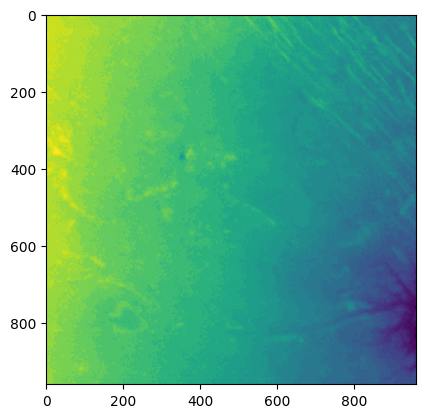

(960, 960)


In [29]:
#@title static sanity check

## set paths and variables

study_area = "kalahari" #@param["kalahari", "simpson"]
data_set = "copdem" #@param["sentinel", "copdem", "alos"]
merged_dataset = "dem" #@param["dem", "sentinel", "curv", "curv_smooth", "dune_height"]

if merged_dataset == "sentinel" or merged_dataset == "dem":
  merge_clip_file_name = f"{study_area}_{data_set}_merged_clip.tif"
elif merged_dataset == "curv" or merged_dataset == "curv_smooth" or merged_dataset == "dune_height":
  merge_clip_file_name = f"{study_area}_{merged_dataset}_merged_clip.tif"

print(merge_clip_file_name)


MERGES_FOLDER_PATH = os.path.join(HOME_PATH, study_area, "img_merged", merged_dataset)

input_vrt = os.path.join(MERGES_FOLDER_PATH, merge_clip_file_name)
output_tif = os.path.join(MERGES_FOLDER_PATH, "sanity_check.tif")
width_extract = 960
height_extract = 960


## extract image

def extract_image_from_vrt(input_vrt, output_tif, width_extract, height_extract):
    # Open the VRT dataset to get its dimensions
    vrt_dataset = gdal.Open(input_vrt)
    if vrt_dataset is None:
        print(f"Error: Unable to open VRT dataset '{input_vrt}'")
        return

    # Get bands and min and max of VRT
    band_count = vrt_dataset.RasterCount

    # Get the width and height of the VRT
    width = vrt_dataset.RasterXSize
    height = vrt_dataset.RasterYSize

    print(f"Bands: {band_count}, Width: {width}, Height: {height}")

    # Generate random offsets within the dimensions of the VRT
    print("offsets:")
    x_offset = random.randint(0, width - 1)
    print(x_offset)
    y_offset = random.randint(0, height - 1)
    print(y_offset)

    # Close the dataset
    vrt_dataset = None

    # extraction of tile
    gdal.Translate(output_tif, input_vrt, srcWin=[x_offset, y_offset, width_extract, height_extract], format='GTiff')


# call function
extract_image_from_vrt(input_vrt, output_tif, width_extract, height_extract)



#### plotting

%matplotlib inline

with rasterio.open(output_tif) as src:

  if src.count >= 3: #for sentinel imagery

    img = src.read()
    print("img shape")
    print(img.shape)

    # Extract color channels and normalise - for sentinel!
    img_blue = img[0, :, :] / 10000
    print(f"old min / nan: {np.min(img_blue)}")
    print(np.min(img_blue))
    print(np.max(img_blue))
    img_green = img[1, :, :] / 10000
    print(np.min(img_green))
    print(np.max(img_green))
    img_red = img[2, :, :] / 10000
    print(np.min(img_red))
    print(np.max(img_red))

    # Stack the channels
    image = np.stack([img_red, img_green, img_blue], axis=-1)

  elif src.count == 1: #for dem etc

    img = src.read(1)
    print(f"old min / nan: {np.min(img)}")
    image = img / 10000

    print(np.min(image))
    print(np.max(image))

  else:
    print("Image has weird number of bands.")



plt.imshow(image)
plt.show()

print(image.shape)

In [ ]:
#@title interactive sanity check

## paths
input_path = output_tif
output_path = os.path.join(MERGES_FOLDER_PATH, "sanity_check_reproj.tif")

%matplotlib inline


## reproject src image to EPSG 4326

# Open the input raster file
with rasterio.open(input_path) as src:

  data = src.read()

  ## transformation of center coordinates
  t = Transformer.from_crs(3857, 4326)
  x, y =  src.bounds[0] + (src.bounds[2] - src.bounds[0]), src.bounds[1] + (src.bounds[3] - src.bounds[1]) # get center of layover image

  # Source and target CRS (Coordinate Reference System)
  src_crs = src.crs
  dst_crs = "EPSG:4326"

  # Calculate the transformation and output dimensions
  transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds)

  # Update metadata to reflect new transformation
  kwargs = src.meta.copy()
  kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
  })

  # Create the output raster file
  with rasterio.open(output_path, 'w', **kwargs) as dst:

      # Perform the reprojection
      for i, band in enumerate(data, 1):

        reproject(
              source=rasterio.band(src, 1), # !! only creates raster with one band
              destination=rasterio.band(dst, 1),
              src_transform=src.transform,
              src_crs=src.crs,
              dst_transform=transform,
              dst_crs=dst_crs,
              resampling=Resampling.nearest  # You can change the resampling method if needed
        )



print(dst.bounds)

bounds=[[dst.bounds[0], dst.bounds[1]], [dst.bounds[2], dst.bounds[3]]]

print(bounds)


# create folium map with lat lon from src image
m = folium.Map(location = t.transform(x, y), zoom_start=10) #x = lat, y = lon

# overlay of satellite image on folium map
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)



# normalise data

if data.shape[0] >= 3: # for sentinel - counts bands

  print("data shape")
  print(data.shape)

  img_blue = data[0, :, :] / 10000
  print(np.min(img_blue))
  print(np.max(img_blue))
  img_green = data[1, :, :] / 10000
  print(np.min(img_green))
  print(np.max(img_green))
  img_red = data[2, :, :] / 10000
  print(np.min(img_red))
  print(np.max(img_red))

  # Stack the channels
  plot_data = np.stack([img_red, img_green, img_blue], axis=-1)


elif data.shape[0] == 1: #for DEM etc - counts bands

  data = data - data.min()
  plot_data = data / data.max()
  print(data.shape)


else:
  print("Weird number of bands.")


# Create an ImageOverlay and add it to the map
image_overlay = folium.raster_layers.ImageOverlay(
    # image=output_path, #path
    image=plot_data.squeeze(),
    bounds=[[dst.bounds[1], dst.bounds[0]], [dst.bounds[3], dst.bounds[2]]],
    opacity=1
    #crs='EPSG4326',
    #interactive=True
)

image_overlay.add_to(m)

m


##**Curvature, Height, Merge**

In [ ]:
#@title curv_height main function

# Script to calculate derivatives of a DEM:
# curvature, smoothed curvature, height (without underlying topography)



def curv_height(study_area,
              data_set,
              derivative,
              sigma_value_curv_smooth,
              sigma_value_dune_height,
              kernel_size_dune_height,
              height_approach,
              path_dem_merge,
              path_curvature,
              path_smoothing,
              path_dune_height):



  ########## CALCULATE CURVATURE ##########
  ## !! This is done in two steps / north south because the richdem curvature seems to have a bug that won't let it process all of a large area

  # check if folder for curvature file exists and create if does not
  print("Folder for curvature image?")
  fun_check_create_folder(path_curvature)


  # check if there is already curvature image of study area

  stop_var = fun_check_folder_file(path_curvature, study_area + '_curv_merged_clip.tif')
  #print(stop_var)

  if derivative != "curvature":
    print("No curvature image will be created.")

  elif derivative == "curvature" and stop_var == 1:
    print("STOP. Curvature image already exists")

  elif derivative == "curvature" and stop_var != 1:

    # load image
    path_merged_img = f"{path_dem_merge}/{study_area}_{data_set}_merged_clip.tif"
    print(path_merged_img)
    dem_img = rasterio.open(path_merged_img)
    print(dem_img.shape)

    # dividing DEM into north and south
    midpoint = dem_img.shape[0] // 2 #rows

    path_file_north = f"{path_curvature}/{study_area}_north_merged_part_clip.tif"
    output_tif = path_file_north
    gdal.Translate(path_file_north, path_merged_img, srcWin=[0, 0, dem_img.shape[1], midpoint], format="GTiff")

    print("north done")

    if dem_img.shape[0] % 2 != 0:
      midpoint += 1

    path_file_south = f"{path_curvature}/{study_area}_south_merged_part_clip.tif"
    output_tif = path_file_south
    gdal.Translate(path_file_south, path_merged_img, srcWin=[0, midpoint + 1, dem_img.shape[1], midpoint])

    print("south done")

    # calculate curvature
    dem_img_north = rd.LoadGDAL(path_file_north, no_data = -99)
    print(dem_img_north.shape)

    dem_img_south = rd.LoadGDAL(path_file_south, no_data = -99)
    print(dem_img_south.shape)


    #dem_curv = rd.TerrainAttribute(dem_img, attrib='profile_curvature') #dem_img
    dem_north_curv = rd.TerrainAttribute(dem_img_north, attrib="profile_curvature")
    dem_south_curv = rd.TerrainAttribute(dem_img_south, attrib="profile_curvature")
    print("calculating curvature done")

    # save curvature images
    rd.SaveGDAL(f"{path_curvature}/{study_area}_north_curv_merged_part_clip.tif", dem_north_curv)
    rd.SaveGDAL(f"{path_curvature}/{study_area}_south_curv_merged_part_clip.tif", dem_south_curv)


    ## create virtual raster of north and south merge

    # list all images available
    list_img_to_merge = glob.glob(path_curvature + "/*curv_merged_part_clip.tif")
    print(list_img_to_merge)

    path_file_curvature = f"{path_curvature}/{study_area}_curv_merged_clip.tif"

    gdal.BuildVRT(path_file_curvature, list_img_to_merge, VRTNodata=-99)
    with rasterio.open(path_file_curvature) as raster:
      pass




  ########## CALCULATE SMOOTHED CURVATURE IMAGE ##########
  ## !! Is done in pieces as otherwise colab crashes

  # check if folder for smoothed curvature file exists and create if does not
  print("Folder for smoothed image?")
  fun_check_create_folder(path_smoothing)


  # check if there is already smoothed curvature image of study area (with same sigma)

  sigma_value_str = str(sigma_value_curv_smooth)

  stop_var = fun_check_folder_file(path_smoothing, study_area + '_curv_smooth_merged_clip.tif')

  if derivative != "smoothed curvature":
    print("No smoothed curvature image will be created.")

  elif derivative == "smoothed curvature" and stop_var == 1:
    print("STOP. Smoothed curvature image already exists")

  elif derivative == "smoothed curvature" and stop_var != 1:

    def curvature_calculation(part):
      # open and read image
      with rasterio.open(f"{path_curvature}/{study_area}_{part}_curv_merged_part_clip.tif") as src:
        open_img = src.read()

      # check if GTiff has been converted to ndarray
      array_test = rasterio.dtypes.is_ndarray(open_img)
      if array_test == False:
        print("STOP. GTiff has not been converted to ndarray!")


      ## smoothing
      dem_curv_smooth = gaussian_filter(open_img, sigma=sigma_value_curv_smooth)


      array_shape = dem_curv_smooth.shape
      #print(array_shape)

      band_nr = array_shape[0]
      print("band nr: ", band_nr)
      array_rows = array_shape[1]
      print("rows: ", array_rows)
      array_columns = array_shape[2]
      print("columns: ", array_columns)

      # transformation into GeoTiff
      f"{path_smoothing}/{study_area}_{part}_curv_smooth_merged_part_clip.tif"

      with rasterio.open(f"{path_smoothing}/{study_area}_{part}_curv_smooth_merged_part_clip.tif",
                          'w',
                          driver='Gtiff',
                          width=array_columns,
                          height=array_rows,
                          count=band_nr,
                          crs=src.crs,
                          transform=src.transform,
                          dtype='float32'
                          ) as name_out:

        name_out.write(dem_curv_smooth)

    print("calculating north")
    curvature_calculation("north")
    print("calculating south")
    curvature_calculation("south")


    ## create virtual raster of north and south merge

    # list all images available
    list_img_to_merge = glob.glob(path_smoothing + "/*curv_smooth_merged_part_clip.tif")
    print(list_img_to_merge)

    path_file_smoothing = f"{path_smoothing}/{study_area}_curv_smooth_merged_clip.tif"

    gdal.BuildVRT(path_file_smoothing, list_img_to_merge, VRTNodata=-99)
    with rasterio.open(path_file_smoothing) as raster:
      pass



  ########## DUNE HEIGHT ##########

  # check if folder for dune height file exists and create if does not
  print("Folder for dune height image?")
  fun_check_create_folder(path_dune_height)


  # check if there is already dune height image of study area (with same kernel size)


  kernel_size_str = str(kernel_size_dune_height)

  stop_var = fun_check_folder_file(path_dune_height, study_area + '_dune_height_merged_clip.tif')

  if derivative != "dune height":
    print("No dune height image will be created.")

  elif derivative == "dune height" and stop_var == 1:
    print("STOP. Dune height image already exists")


  elif derivative == "dune height" and stop_var != 1:



    # open image
    path_merged_img = path_merged_img = f"{path_dem_merge}/{study_area}_{data_set}_merged_clip.tif"
    open_dem = rasterio.open(path_merged_img)


    # turn GTiff into ndarray
    dem = open_dem.read()
    print(dem.shape)

    # check if GTiff has been converted to ndarray
    array_test = rasterio.dtypes.is_ndarray(dem)
    if array_test == False:
      print("STOP. GTiff has not been converted to ndarray!")


    ## Calculating dune height by subtracting underlying topography, different approaches

    # minimum filter
    if height_approach == 'min':

      dem_min = minimum_filter(dem, size=kernel_size_dune_height) # underlying topo

      sigma_value_str = str(sigma_value_dune_height)
      dem_min_smooth = gaussian_filter(dem_min, sigma=sigma_value_dune_height) #smoothing

      # final dune height
      dune_height = dem - dem_min_smooth


    # medium filter
    if height_approach == 'median':

      dem_median = median_filter(dem, size=kernel_size_dune_height) # underlying topo

      sigma_value_str = str(sigma_value_dune_height)
      dem_median_smooth = gaussian_filter(dem_median, sigma=sigma_value_dune_height)

      # final dune height
      dune_height = dem - dem_median_smooth



    # tophat filter
    if height_approach == 'tophat':
      # final dune height (no smoothing necessary)
      dune_height = white_tophat(dem, size = kernel_size_dune_height)


    array_shape = dune_height.shape
    #print(array_shape)

    band_nr = array_shape[0]
    print("band nr: ", band_nr)
    array_rows = array_shape[1]
    print("rows: ", array_rows)
    array_columns = array_shape[2]
    print("columns: ", array_columns)


    ## transformation into GeoTiff

    if height_approach == 'min': # minimum filter approach
      with rasterio.open(path_dune_height + '/' + study_area + '_' + kernel_size_str + '-min_' + sigma_value_str + '-smt.tif',
                      'w',
                      driver='Gtiff',
                      width=array_columns,
                      height=array_rows,
                      count=band_nr,
                      crs=open_dem.crs,
                      transform=open_dem.transform,
                      dtype='float32'
                      ) as name_out:

        name_out.write(dem_min_smooth)


    if height_approach == 'median': # median filter approach
      with rasterio.open(path_dune_height + '/' + study_area + "_dune-height-median-" + kernel_size_str + '_' + sigma_value_str + "-smt.tif",
                      'w',
                      driver='Gtiff',
                      width=array_columns,
                      height=array_rows,
                      count=band_nr,
                      crs=open_dem.crs,
                      transform=open_dem.transform,
                      dtype='float32'
                      ) as name_out:

        name_out.write(dune_height)


    if height_approach == 'tophat': # tophat approach
      with rasterio.open(path_dune_height + '/' + study_area + "_dune_height_merged_clip.tif",
                      'w',
                      driver='Gtiff',
                      width=array_columns,
                      height=array_rows,
                      count=band_nr,
                      crs=open_dem.crs,
                      transform=open_dem.transform,
                      dtype='float32'
                      ) as name_out:

        name_out.write(dune_height)

In [ ]:
#@title curvature & height variables, paths, execution
## import richdem - not in general imports because takes v long

!pip install richdem
import richdem as rd


## variables

study_area = "kalahari" #@param ["simpson", "kalahari"]
data_set = "copdem" #@param["copdem", "alos"]
derivative = "dune height" #@param ["curvature", "smoothed curvature", "dune height"]

#@markdown Needed for Smoothed Curvature:
sigma_value_curv_smooth = 3 #@param{"type": "integer"}
#@markdown Needed for Dune Height:
sigma_value_dune_height = 3 #@param{"type": "integer"}
kernel_size_dune_height = 50 #@param{"type": "integer"}
height_approach = "tophat" #@param ["minimum", "median", "tophat"]

## paths

OVERALL_MERGES_FOLDER_PATH = os.path.join(HOME_PATH, study_area, "img_merged")
DEM_MERGE_FOLDER_PATH = os.path.join(OVERALL_MERGES_FOLDER_PATH, "dem")
CURV_MERGE_FOLDER_PATH = os.path.join(OVERALL_MERGES_FOLDER_PATH, "curv")
CURVSMOOTH_MERGE_FOLDER_PATH = os.path.join(OVERALL_MERGES_FOLDER_PATH, "curv_smooth")
DUNEHEIGHT_MERGE_FOLDER_PATH = os.path.join(OVERALL_MERGES_FOLDER_PATH, "dune_height")


# run function

curv_height(study_area,
            data_set,
            derivative,
            sigma_value_curv_smooth,
            sigma_value_dune_height,
            kernel_size_dune_height,
            height_approach,
            DEM_MERGE_FOLDER_PATH,
            CURV_MERGE_FOLDER_PATH,
            CURVSMOOTH_MERGE_FOLDER_PATH,
            DUNEHEIGHT_MERGE_FOLDER_PATH)

##**Tiling**

In [ ]:
#@title create csv function
def create_tile_csv(path_files, path_csv, prefix, suffix):

  filename=[]

  print(path_files)

  for f in os.listdir(path_files):
      if f.startswith(prefix) and f.endswith(suffix):
          filename.append(f)
          print(f)


  #column name of the sheet
  df=pd.DataFrame(list(zip(filename)),columns=["filename"])

  df["i"] = df["filename"].apply(lambda x: re.findall(r'\d+', x)[0]) # x is f!
  df["j"] = df["filename"].apply(lambda x: re.findall(r'\d+', x)[1]) # x is f!


  print(df)

  #change the file to excel sheet
  df.to_csv(path_csv)


In [ ]:
#@title main tiling function
########## DEF TILING SCRIPT ##########

def tiling(home_dir,
           tiling_train_test,
           study_area,
           tile_size,
           nr,
           tiles_choice,
           pixel_size,
           tile_type,
           tiles_in_path,
           path_study_area_merge,
           output_filename,
           img_to_csv_folder,
           path_csv_file,
           prefix,
           suffix
           ):



########## PREPARATIONS #########


  if tiling_train_test == "train":
    tiles_out_path = os.path.join(home_dir, study_area, "pp_data", "train_pp", tile_type)
    fun_check_create_folder(tiles_out_path)


  elif tiling_train_test == "test":
    tiles_size_folder_path = os.path.join(home_dir, study_area, "pp_data", "test_pp", "tiles_" + str(tile_size))
    tiles_out_path = os.path.join(tiles_size_folder_path, tile_type)
    fun_check_create_folder(tiles_size_folder_path)
    fun_check_create_folder(tiles_out_path)



  else:
    print("You need to choose train or test data.")



  # check if there is merged clipped image of study area
  stop_var_merge_clip = fun_check_folder_file(path_study_area_merge, f"{tile_type}_merged_clip.tif")
  print('nr of clip imgs: ', stop_var_merge_clip)


  # define variable for merged and clipped image fifle
  merge_clip_file = f"{study_area}_{tile_type}_merged_clip.tif"



########## CREATING TILES - random or all or specific tiles ##########

  ## determine tile size
  tile_size_x = tile_size
  tile_size_y = tile_size

  count = 0


  ## RANDOM tiles

  if tiles_choice == "random":

      print("Creating ", nr, " random tiles of size ", tile_size, ".")

      ds = gdal.Open(tiles_in_path)

      if tiles_in_path is None:
        print(f"Error: Unable to open dataset {ds}")
        return

      # get bands
      band_num = ds.RasterCount

      # Get raster size
      xsize = ds.RasterXSize
      ysize = ds.RasterYSize

      # generate random offsets within dimension of raster for nr of images
      for lp in range(nr):

        ran_i = random.randint(0, xsize - tile_size_x)
        ran_j = random.randint(0, ysize - tile_size_y)

        ds = None

        # extraction of tile
        output_tif = os.path.join(tiles_out_path, f"{output_filename}{str(ran_i)}_{str(ran_j)}_img.tif")
        gdal.Translate(output_tif, tiles_in_path, srcWin=[ran_i, ran_j, tile_size_x, tile_size_y], format="GTiff")


        # counter to show progress of tile creation
        count += 1
        if count % 10 == 0:
            print(count, "/", nr, " tiles created")




  ## ALL tiles
  elif tiles_choice == "all":

    print("Creating tiles of whole study area.")

    ds = gdal.Open(tiles_in_path)

    if tiles_in_path is None:
      print(f"Error: Unable to open dataset {ds}")

    # get raster size
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize

    for i in range(0, xsize, tile_size_x):
      for j in range(0, ysize, tile_size_y):

        ds = None

        # extraction of tile
        output_tif = os.path.join(tiles_out_path, f"{output_filename}{str(i)}_{str(j)}_img.tif")
        gdal.Translate(output_tif, tiles_in_path, srcWin=[i, j, tile_size_x, tile_size_y], format="GTiff")

        # counter to show progress of tile creation
        count += 1
        if count % 10 == 0:
          print(count, "tiles created")



  ## SPECIFIC tiles

  elif tiles_choice == "specific":

    print("Creating specific tiles.")


    ## get size of input
    ds = gdal.Open(tiles_in_path)

    if tiles_in_path is None:
      print(f"Error: Unable to open dataset {ds}")

    # get raster size
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize

    ## create tiles running through CSV

    # create csv
    create_tile_csv(img_to_csv_folder, path_csv_file, prefix, suffix)

    if path_csv_file is None:
      print("Error: Unable to open csv file.")

    csv = pd.read_csv(path_csv_file)

    for idx in range(len(csv)):
      i = csv.iloc[idx, 2]
      print(i)
      j = csv.iloc[idx, 3]
      print(j)

      ds = None

      # extraction of tile
      output_tif = os.path.join(tiles_out_path, f"{output_filename}{str(i)}_{str(j)}_img.tif")
      gdal.Translate(output_tif, tiles_in_path, srcWin=[i, j, tile_size_x, tile_size_y], format="GTiff")


      print("tile created")


  else:
    print("You need to choose specific tiles or random ones.")

In [ ]:
#@title tiling paths, variables, execution

## variables

study_area = "kalahari" #@param ["simpson", "kalahari"]
data_set = "copdem" #@param["sentinel", "copdem", "alos"]
tile_type = "dem" #@param["dem", "dune_height", "sentinel", "curv", "curv_smooth"]
train_test = "test" #@param["train", "test"]

tile_size = 4800 #@param{"type": "integer"}
tile_nr = 2 #@param{"type": "integer"}
pixel_size = 10 #@param{"type": "integer"}

#@markdown Speficic tiles, random tiles, or all tiles?
tiles_choice = "all" #@param["specific", "random", "all"]



## paths

OVERALL_MERGES_FOLDER_PATH = os.path.join(HOME_PATH, study_area, "img_merged")
MERGE_FOLDER_PATH = os.path.join(OVERALL_MERGES_FOLDER_PATH, tile_type)

if tile_type == "sentinel" or tile_type == "dem":
  merge_clip_file_name = f"{study_area}_{data_set}_merged_clip.tif"
elif tile_type == "curv" or tile_type == "curv_smooth" or tile_type == "dune_height":
  merge_clip_file_name = f"{study_area}_{tile_type}_merged_clip.tif"

MERGE_FILE_PATH = os.path.join(MERGE_FOLDER_PATH, merge_clip_file_name)

output_filename = f"{study_area}_tile_{tile_type}_"

# csv paths
#@markdown CSV creation:
img_to_csv_folder = "train_pp/labels" #@param{"type": "string"}
IMG_TO_CSV_FOLDER_PATH = os.path.join(HOME_PATH, study_area, "pp_data", img_to_csv_folder)
csv_file_name = f"file_overview_{study_area}_{tile_size}_{train_test}.csv"
CSV_FILE_PATH = os.path.join(IMG_TO_CSV_FOLDER_PATH, csv_file_name)
#@markdown prefix for images to create csv from
prefix = "tile_" #@param{"type": "string"}
#@markdown suffix for images to create csv from
suffix = "cr-label.tif" #@param["_img.tif", "cr-label.tif"]


## call function

tiling(HOME_PATH,
       train_test,
       study_area,
       tile_size,
       tile_nr,
       tiles_choice,
       pixel_size,
       tile_type,
       MERGE_FILE_PATH,
       MERGE_FOLDER_PATH,
       output_filename,
       IMG_TO_CSV_FOLDER_PATH,
       CSV_FILE_PATH,
       prefix,
       suffix)


Folder exists.
Created folder.
path: /content/drive/MyDrive/DUNEMINDS_data/kalahari/img_merged/dem
file suffix: dem_merged_clip.tif
nr of clip imgs:  1
Creating tiles of whole study area.
10 tiles created
20 tiles created
30 tiles created
40 tiles created
50 tiles created
60 tiles created
70 tiles created
80 tiles created
90 tiles created
100 tiles created
110 tiles created
120 tiles created
130 tiles created
140 tiles created
150 tiles created
160 tiles created
170 tiles created
180 tiles created
190 tiles created
200 tiles created


##**Data Pre-Processing**

In [31]:
#@title function to check if tiles are already pre-processed and in right shape
######### function to check if tiles are in right shape, preprocessed etc ##########

def preprocess_check(path_in_pp,
                    file_suffix,
                    pixel_size,
                    bn,
                    pixel_nr,
                    nodata_value
                    ):

  images = os.listdir(path_in_pp)
  num_images = 0 #to count total images later
  num_images_nonorm = 0 #to count images that have not been normalised later
  num_images_zero = 0 #to count images that are just black later
  normalisation_choice = None

  for i, image_name in enumerate(images):
    if image_name.endswith(file_suffix) == True:

      num_images += 1

      img = rasterio.open(os.path.join(path_in_pp, image_name))

      # check if resampling is necessary - Is pixel size 10m?
      img_info = img.transform
      #print(img_info)
      pxl_sz_X = img_info[0]
      pxl_sz_Y = img_info[4]
      #print("pixel size X: ", pxl_sz_X)
      #print("pixel size Y: ", pxl_sz_Y)

      if pxl_sz_X != pixel_size or pxl_sz_Y != (-1 * pixel_size):
        sys.exit("STOP. Pixel size is not ", pixel_size, "m - need to resample.")

      img = img.read()
      # check if GTiff has been converted to ndarray
      array_test = rasterio.dtypes.is_ndarray(img)
      if array_test == False:
        print("STOP. GTiff has not been converted to ndarray!")

      ## check if normalisation was done correctly/already
      min_value = np.min(img)
      print(min_value)
      max_value = np.max(img)
      print(max_value)

      if min_value == 0 and max_value == 1:
        print(f"{image_name} is normalised to 0-1")

      # how many images are NOT normalised
      elif min_value != 0 or max_value != 1:
        num_images_nonorm +=1
        print(f"{image_name} not normalised")

        # how many images just have 1 value
        if min_value == max_value:
          print(f"{image_name} just one value - remove")
          if min_value == nodata_value:
            os.remove(os.path.join(path_in_pp, image_name))
            print("removed")
            num_images_zero +=1 #likely black images with only zero - cannot / does not need to be normalised
          elif min_value != nodata_value:
            sys.exit("!! Problem with no data value - either not correct or img has been pre-processed already. In that case change nodata value to 0 !!")

      else:
        print(f"{image_name} huh?!")

      ## check if TARGET SIZE of array and BAND SIZE are correct
      array_shape = img.shape
      #print(array_shape)

      band_nr = array_shape[0]
      #print("band nr: ", band_nr)
      array_rows = array_shape[1]
      #print("rows: ", array_rows)
      array_columns = array_shape[2]
      #print("columns: ", array_columns)

      if band_nr != bn or array_rows != pixel_nr or array_columns != pixel_nr:
        print(image_name)
        sys.exit("STOP. Array does not have correct dimensions and/or target size.")

  print('Images checked.')
  print(f"num_images_nonorm: {num_images_nonorm}")
  print(f"num_images_zero:{num_images_zero}")
  print(f"num_images:{num_images}")
  print(f"{num_images_nonorm} out of {num_images} are NOT normalised.")
  print(f"{num_images_zero} out of {num_images} only have one value (possibly all black / zero).") #only one value cannot be normalised

  # there are no images that need to be normalised
  if num_images_nonorm == 0: #those with all same value do not matter in that case
    print("No normalisation needed.")
    normalisation_choice = False

  # there are some images that are not min 0 AND max 1
  else:

    # if all images are either to normalise or ones with all same value normalisation will be carried out
    if num_images_nonorm == num_images:
      print("Normalisation will be / needs to be carried out.")
      normalisation_choice = True

    else:
      if num_images_nonorm != num_images_zero:
        print("It seems like only some images are not min 0 max 1 or all same values.")

      else:
        print("It's fine, the only non normalised images are the ones with all same value.")


  return normalisation_choice


In [30]:
#@title main preprocessing functions

def match_histogram(image, reference):
  return match_histograms(image, reference, multichannel=False)

def preprocessing_data(path_images,
              suffix,
              pixel_size,
              band_number,
              tile_size,
              nodata_value,
              reference_image_folder):

  if tile_size != 96:

    ## preparing reference image
    reference_images = []
    for image_name in os.listdir(reference_image_folder):
      if image_name.endswith(suffix):
        reference_path = os.path.join(reference_image_folder, image_name)
        with rasterio.open(reference_path) as ref_src:
          reference_img = ref_src.read()
          reference_images.append(reference_img)

    # Concatenate reference images along a new axis
    reference_array = np.concatenate(reference_images, axis=0)
    print(reference_array.shape)


  ########## check if data exists ##########

  stop_var = fun_check_folder_file(path_images, suffix) #used to be path_train

  if stop_var >= 1:
    print("Nr of images: ", stop_var)
    train_nr = stop_var

  else:
    sys.exit("STOP. No data existing.")



  ########## PREPROCESSING DATA: TRAINING / VALIDATION IMAGES ##########

  images = os.listdir(path_images)

  if normalisation_choice: #only if normalisation required / not done yet

    ## applying normalisation to training / vali / test data
    # read all images in folder holding original data
    for k, image_name in enumerate(images):
      if image_name.endswith(suffix):
        print(image_name)

        img_pp = [] #empty list to store preprocessed array

        path_in_image = os.path.join(path_images, image_name)

        with rasterio.open(path_in_image) as src: #open original files
          for m, band in enumerate(range(1, src.count + 1)): #go through bands individually

            img_band = src.read(band) #read bands as np array

            # check if GTiff has been converted to ndarray
            array_test = rasterio.dtypes.is_ndarray(img_band)
            if array_test == False:
              sys.exit("STOP. GTiff has not been converted to ndarray!")

            # convert to float if it isn't float already
            data_type = img_band.dtype
            if data_type != np.float32:
              img_band = img_band.astype(np.float32)


            ## turn all -99 / no data into 0
            img_band[img_band == nodata_value] = 0

            band_min = np.nanmin(img_band) # calculate min max values for current tile / band
            band_max = np.nanmax(img_band)
            band_range = band_max - band_min

            ## if image is all the same value (e.g. black / zero one) - no normalisation, just copy values
            if band_min == band_max:
              img_pp.append(np.array(img_band))


            ## if image has different values
            else:
              # last check if image needs to be normalised (i.e. is not min 0 or max 1)
              # normalisation for training data with 96x96!
              if (band_min != 0 or band_max != 1) and tile_size == 96: # check if currently open tile / band is already normalised to 0-1 range
                img_band_pp = (img_band - band_min) / band_range # calculate NORMALISATION
                #print(img_band_pp)
                img_pp.append(np.array(img_band_pp)) # stack bands of each file to create multiband array

              # normalisation for test data with NOT 96x96!
              elif (band_min != 0 or band_max != 1) and tile_size != 96:
                print("match histogram")
                print(img_band.shape)
                print(reference_array[band-1].shape)
                img_band_pp = match_histogram(img_band, reference_array[band-1])
                img_pp.append(np.array(img_band_pp)) # stack bands of each file to create multiband array

              else:
                sys.exit("Something is wrong - check images.")


          img_pp = np.array(img_pp) # create np array from img_pp list

          ## calculate parameters for export
          array_shape = img_pp.shape
          #print(array_shape)
          band_nr = array_shape[0]
          #print("band nr: ", band_nr)
          array_rows = array_shape[1]
          #print("rows: ", array_rows)
          array_columns = array_shape[2]
          #print("columns: ", array_columns)


          ## transformation into GeoTiff
          path_out_image = f"{path_images}/{image_name}"

          with rasterio.open(path_out_image,
                              'w',
                              driver='Gtiff',
                              width=array_rows,
                              height=array_columns,
                              count=band_nr,
                              crs=src.crs,
                              transform=src.transform,
                              dtype='float32'
                              ) as name_out:

            name_out.write(img_pp)

    print("Pre-processing done.")


    ## check if pre-processing worked
    print("Check post pre-processing.")
    nodata_value = 0 #set nodata_value to 0 - changed during preprocessing
    preprocess_check(path_images,
                    suffix,
                    pixel_size,
                    band_number,
                    tile_size,
                    nodata_value)


In [32]:
#@title preprocessing paths, variables, execution { form-width: "30%" }

## variables

study_area = "kalahari" #@param ["simpson", "kalahari"]
tile_type = "sentinel" #@param["dem", "dune_height", "sentinel", "curv", "curv_smooth", "labels"]
train_test = "train" #@param["train", "test"]
tile_size = 96 #@param{"type": "integer"}

pixel_size = 10 #@param{"type": "integer"}
band_number = 4 #@param{"type": "integer"}

#@markdown No Data Value dem, curv: -99; curv smooth: -9999; dune height, sentinel, labels: 0
nodata_value = 0 #@param{"type": "integer"}

reference_hm_folder_path = os.path.join(HOME_PATH, study_area, "pp_data", "train_pp", tile_type)



## paths
if train_test == "train":
  TILES_FOLDER_PATH = os.path.join(HOME_PATH, study_area, "pp_data", "train_pp", tile_type)

elif train_test == "test":
  TILES_FOLDER_PATH = os.path.join(HOME_PATH, study_area, "pp_data", "test_pp", "tiles_" + str(tile_size), tile_type)



output_filename = f"{study_area}_tile_{tile_type}_"

## run function to check if normalisation has been done already
normalisation_choice = preprocess_check(TILES_FOLDER_PATH,
                                        ".tif", # file suffix
                                        pixel_size,
                                        band_number,
                                        tile_size,
                                        nodata_value)



## run pre-processing
if normalisation_choice:

  if tile_type == "labels":
    sys.exit("Labels should not need normalisation. Check labels")

  else:

    preprocessing_data(TILES_FOLDER_PATH,
                      ".tif",
                      pixel_size,
                      band_number,
                      tile_size,
                      nodata_value,
                      reference_hm_folder_path,
                      train_test) #leave out for blocks


else:
  print("No further pre-processing necessary.")


0.0
1.0
kalahari_tile_sentinel_32736_36480_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_46752_63648_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_33216_35328_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_31488_39360_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_34272_50688_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_32064_47712_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_34080_47520_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_30240_47040_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_52512_56448_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_47520_54720_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_33792_49632_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_53280_67680_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_53568_63456_img.tif is normalised to 0-1
0.0
1.0
kalahari_tile_sentinel_51648_67296_img.tif is normalised

##**Training & Validation**

In [33]:
#@title custom metrics

def iou(y_true, y_pred):
  smooth = 1
  y_pred = tf.cast(tf.greater_equal(y_pred, prediction_threshold), tf.float32)  # Apply thresholding
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
  iou_score = (intersection + smooth) / (union + smooth)
  iou_score = iou_score
  return iou_score

def iou_metric(y_true, y_pred):
  return iou(y_true, y_pred)


def tiou(y_true, y_pred):

  c = tf.constant(0.5)

  w = tf.ones([3,3,1,1], dtype=tf.dtypes.float32)

  y_true = tf.cast(tf.greater_equal(y_true, prediction_threshold), tf.float32)  # Apply thresholding
  y_pred = tf.cast(tf.greater_equal(y_pred, prediction_threshold), tf.float32)  # Apply thresholding

  y_true_conv = tf.nn.convolution(y_true, w, padding="SAME", strides=1)>=1
  y_pred_conv = tf.nn.convolution(y_pred, w, padding="SAME", strides=1)>=1

  y_true_conv = tf.cast(y_true_conv, dtype=tf.dtypes.float32)
  y_pred_conv = tf.cast(y_pred_conv, dtype=tf.dtypes.float32)


  y_true_tiered = (y_true_conv * c) + (y_true * c)

  y_pred_tiered = (y_pred_conv * c) + (y_pred * c)


  intersection_full = tf.math.logical_or(tf.math.logical_and(y_true_tiered == 1.0, y_pred_tiered == 1.0),
                                    tf.math.logical_and(y_true_tiered == 0.5, y_pred_tiered == 0.5))

  intersection_full = tf.cast(intersection_full, tf.float32)

  intersection_lim_1 = tf.math.logical_or(tf.math.logical_and(y_true_tiered == 0.5, y_pred_tiered == 1.0),
                                   tf.math.logical_and(y_true_tiered == 1.0, y_pred_tiered == 0.5))

  intersection_lim_1 = tf.cast(intersection_lim_1, tf.float32)

  intersection_lim_2 = tf.math.logical_or(tf.math.logical_and(y_true_tiered == 0.0, y_pred_tiered == 0.5),
                                   tf.math.logical_and(y_true_tiered == 0.5, y_pred_tiered == 0.0))

  intersection_lim_2 = tf.cast(intersection_lim_2, tf.float32)

  union_tiered = tf.math.logical_or(y_true_tiered != 0.0, y_pred_tiered != 0.0)

  union_tiered = tf.cast(union_tiered, tf.float32)

  intersection_total = tf.math.reduce_sum(intersection_full) + (tf.math.reduce_sum(intersection_lim_1) * 0.75) + (tf.math.reduce_sum(intersection_lim_2) * 0.5)
  union_total = tf.math.reduce_sum(union_tiered)

  iou_tiered = intersection_total / union_total

  return iou_tiered

@keras.saving.register_keras_serializable()
def tiou_metric(y_true, y_pred):
  return tiou(y_true, y_pred)



def false_positive(y_true, y_pred):
  y_pred = tf.cast(tf.greater_equal(y_pred, prediction_threshold), tf.float32)  # Apply thresholding
  intersection = tf.reduce_sum(y_true * y_pred)
  false_positive_score = intersection + 0.0000001 / y_true + 0.0000001
  return false_positive_score

def false_positive_metric(y_true, y_pred):
  return false_positive(y_true, y_pred)

In [34]:
#@title model functions


########## UNET MODEL SMALL ########## smallest 48x48

def unet_model_small(img_height, img_width, img_bands, seed, optimizer, metric, prediction_threshold):
  keras.utils.set_random_seed(seed)
  inputs = Input((None, None, img_bands))
  s = inputs

  #Contraction path
  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(s)
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  c1 = Dropout(0.1)(c1)

  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  print(tf.shape(c1))
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  c2 = Dropout(0.1)(c2)

  c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  ## new
  c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
  c5 = BatchNormalization()(c5)
  c5 = Activation(activation_1)(c5)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c5)

  ### expansive


  ## new
  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
  u8 = concatenate([u8, c2])
  u8 = BatchNormalization()(u8)  # Add batch normalization after up-sampling
  u8 = Activation(activation_1)(u8)

  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = BatchNormalization()(c8)  # Add batch normalization after up-sampling
  c8 = Activation(activation_1)(c8)
  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)


  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  u9 = BatchNormalization()(u9)
  u9 = Activation(activation_1)(u9)

  c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = BatchNormalization()(c9)
  c9 = Activation(activation_1)(c9)
  c9 = Conv2D(16, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(1, (1, 1), activation=activation_2)(c9)

  model = Model(inputs=[inputs], outputs=[outputs])



  ########## compile model using custom or keras loss / accuracy metric ##########

  if metric == "iou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[iou_metric])

  # elif metric == "tiou_metric":
  #   model.compile(optimizer=optimizer, loss=loss, metrics=[tiou_metric])

  elif metric == "false_positive_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[false_positive_metric])

  else:
    all_metrics = []
    for th in np.linspace(0.3, 0.8, 6):
      all_metrics.append(tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=th, name = f"binary_iou_{th}" if th!=0.5 else "binary_iou"))

      all_metrics.append(tf.keras.metrics.TruePositives(thresholds=th, name = f"true_positives_{th}"))
      all_metrics.append(tf.keras.metrics.FalsePositives(thresholds=th, name = f"false_positives_{th}"))

    all_metrics.append(tiou_metric)
    all_metrics.append(tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name = "ROC"))

    # model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=prediction_threshold, name = "binary_iou")])

    model.compile(optimizer=optimizer, loss=loss, metrics=all_metrics)

  #model.compile(optimizer=optimizer, loss=loss, metrics=metric)
  #model.summary()

  return model



########## UNET MODEL MEDIUM ########## smallest 12x12

def unet_model_medium(img_height, img_width, img_bands, seed, optimizer, metric, prediction_threshold):
  keras.utils.set_random_seed(seed)
  inputs = Input((None, None, img_bands))
  s = inputs

  #Contraction path
  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(s)
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  c1 = Dropout(0.1)(c1)

  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  print(tf.shape(c1))
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  c2 = Dropout(0.1)(c2)

  c2 = Conv2D(32, (3, 3),  kernel_initializer='he_normal', padding='same')(c2)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
  c3 = BatchNormalization()(c3)
  c3 = Activation(activation_1)(c3)
  c3 = Dropout(0.2)(c3)

  c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
  c3 = BatchNormalization()(c3)
  c3 = Activation(activation_1)(c3)
  p3 = MaxPooling2D((2, 2))(c3)


  c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
  c5 = BatchNormalization()(c5)
  c5 = Activation(activation_1)(c5)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c5)


  # #Expansive path
  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
  u7 = concatenate([u7, c3])
  u7 = BatchNormalization()(u7)  # Add batch normalization after up-sampling
  u7 = Activation(activation_1)(u7)

  c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = BatchNormalization()(c7)  # Add batch normalization after up-sampling
  c7 = Activation(activation_1)(c7)
  c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c7)


  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  u8 = BatchNormalization()(u8)  # Add batch normalization after up-sampling
  u8 = Activation(activation_1)(u8)

  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = BatchNormalization()(c8)  # Add batch normalization after up-sampling
  c8 = Activation(activation_1)(c8)
  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)


  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  u9 = BatchNormalization()(u9)
  u9 = Activation(activation_1)(u9)

  c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = BatchNormalization()(c9)
  c9 = Activation(activation_1)(c9)
  c9 = Conv2D(16, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(1, (1, 1), activation=activation_2)(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  ########## compile model using custom or keras loss / accuracy metric ##########

  if metric == "iou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[iou_metric])

  elif metric == "tiou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[tiou_metric])

  elif metric == "false_positive_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[false_positive_metric])

  else:
    all_metrics = []
    for th in np.linspace(0.3, 0.8, 6):
      all_metrics.append(tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=th, name = f"binary_iou_{th}" if th!=0.5 else "binary_iou"))

      all_metrics.append(tf.keras.metrics.TruePositives(thresholds=th, name = f"true_positives_{th}"))
      all_metrics.append(tf.keras.metrics.FalsePositives(thresholds=th, name = f"false_positives_{th}"))

    all_metrics.append(tiou_metric)
    all_metrics.append(tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name = "ROC"))

    # model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=prediction_threshold, name = "binary_iou")])

    model.compile(optimizer=optimizer, loss=loss, metrics=all_metrics)

  #model.summary()

  return model




########## UNET MODEL LARGE ##########

def unet_model_large(img_height, img_width, img_bands, seed, optimizer, metric, prediction_threshold):

  keras.utils.set_random_seed(seed)
  inputs = Input((None, None, img_bands))
  s = inputs

  dropout_value_1 = 0.1
  dropout_value_2 = 0.2
  dropout_value_3 = 0.3

  #Contraction path
  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(s) #padding=same means output size is same dimeansions as input
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  c1 = Dropout(dropout_value_1)(c1) #random deactivation of neurons to prevent overfitting

  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  print(tf.shape(c1))
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  c2 = Dropout(dropout_value_1)(c2)

  c2 = Conv2D(32, (3, 3),  kernel_initializer='he_normal', padding='same')(c2)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
  c3 = BatchNormalization()(c3)
  c3 = Activation(activation_1)(c3)
  c3 = Dropout(dropout_value_2)(c3)

  c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
  c3 = BatchNormalization()(c3)
  c3 = Activation(activation_1)(c3)
  p3 = MaxPooling2D((2, 2))(c3)


  c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
  c4 = BatchNormalization()(c4)
  c4 = Activation(activation_1)(c4)
  c4 = Dropout(dropout_value_2)(c4)

  c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
  c4 = BatchNormalization()(c4)
  c4 = Activation(activation_1)(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)


  c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
  c5 = BatchNormalization()(c5)
  c5 = Activation(activation_1)(c5)
  c5 = Dropout(dropout_value_3)(c5)
  c5 = Conv2D(256, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c5)



  #Expansive path
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  u6 = BatchNormalization()(u6)  # Add batch normalization after up-sampling
  u6 = Activation(activation_1)(u6)

  c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(dropout_value_2)(c6)
  c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
  c6 = BatchNormalization()(c6)  # Add batch normalization after up-sampling
  c6 = Activation(activation_1)(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
  u7 = concatenate([u7, c3])
  u7 = BatchNormalization()(u7)  # Add batch normalization after up-sampling
  u7 = Activation(activation_1)(u7)

  c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(dropout_value_2)(c7)
  c7 = BatchNormalization()(c7)  # Add batch normalization after up-sampling
  c7 = Activation(activation_1)(c7)
  c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  u8 = BatchNormalization()(u8)  # Add batch normalization after up-sampling
  u8 = Activation(activation_1)(u8)

  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(dropout_value_1)(c8)
  c8 = BatchNormalization()(c8)  # Add batch normalization after up-sampling
  c8 = Activation(activation_1)(c8)
  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)


  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  u9 = BatchNormalization()(u9)
  u9 = Activation(activation_1)(u9)

  c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(dropout_value_1)(c9)
  c9 = BatchNormalization()(c9)
  c9 = Activation(activation_1)(c9)
  c9 = Conv2D(16, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(1, (1, 1), activation=activation_2)(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  ########## compile model using custom or keras loss / accuracy metric ##########

  if metric == "iou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[iou_metric])

  elif metric == "tiou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[tiou_metric])

  elif metric == "false_positive_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[false_positive_metric])

  else:
    all_metrics = []
    for th in np.linspace(0.3, 0.8, 6):
      all_metrics.append(tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=th, name = f"binary_iou_{th}" if th!=0.5 else "binary_iou"))

      all_metrics.append(tf.keras.metrics.TruePositives(thresholds=th, name = f"true_positives_{th}"))
      all_metrics.append(tf.keras.metrics.FalsePositives(thresholds=th, name = f"false_positives_{th}"))

    all_metrics.append(tiou_metric)
    all_metrics.append(tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name = "ROC"))

    # model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=prediction_threshold, name = "binary_iou")])

    model.compile(optimizer=optimizer, loss=loss, metrics=all_metrics)

  #model.summary()

  return model

In [35]:
#@title tiered IoU functions


########## turning neighbour cells of 1 into 0.5 ##########

# idea: create different tiered IoU versions:
# one with just bigger buffer (cf chatgpt)
# one with tiered bigger buffer (first run big buffer, then update with small buffer) - inner one gets updated to 1, outer to 0.5?


def simple_buffer(arr, extension_nr, tier_round):

  instances = arr.shape[0]
  rows = arr.shape[1]
  cols = arr.shape[2]

  if arr.dtype != np.float32:  # Check if the array is not already of float type
    result = arr.astype(np.float32)  # Convert the array to float
  else:
    result = np.copy(arr)  # Create a copy of the float array

  for i in range(instances):

    for row in range(rows):

      for col in range(cols):

        if arr[i, row, col] == 0:
          # Check 8-way neighborhood
          for r in range(row - extension_nr, row + extension_nr + 1):
            for c in range(col - extension_nr, col + extension_nr + 1):
              if (0 <= r < rows) and (0 <= c < cols) and arr[i, r, c] == 1: #checks if the neighbouring cells are 1 and that the row index is within the bounds of the array's row
                if tier_round == 1:
                  result[i, row, col] = 2
                elif tier_round == 2:
                  result[i, row, col] = 3

  return result



########## function to calculate tiered IoU ##########

def calculate_tiered_iou(tier_value_1: float, tier_value_2: float, prediction_data, ground_truth_data, extension_1, extension_2, second_tier_decision):

  prediction_data_upd = simple_buffer(prediction_data, extension_1, tier_round=1)
  ground_truth_data_upd = simple_buffer(ground_truth_data, extension_1, tier_round=1)

  if second_tier_decision:
    prediction_data_upd = simple_buffer(prediction_data_upd, extension_2, tier_round=2)
    ground_truth_data_upd = simple_buffer(ground_truth_data_upd, extension_2, tier_round=2)

  print(prediction_data_upd.shape)

  # Calculating full intersection
  intersection_full = np.logical_or(np.logical_and(prediction_data_upd == 1.0, ground_truth_data_upd == 1.0),
                                   np.logical_and(prediction_data_upd == 2.0, ground_truth_data_upd == 2.0),
                                    np.logical_and(prediction_data_upd == 3.0, ground_truth_data_upd == 3.0))

  # calculating limited intersections
  intersection_lim_1 = (
      (prediction_data_upd == 1.0) & (ground_truth_data_upd == 2.0) |
      (prediction_data_upd == 2.0) & (ground_truth_data_upd == 1.0) |
      (prediction_data_upd == 2.0) & (ground_truth_data_upd == 3.0) |
      (prediction_data_upd == 3.0) & (ground_truth_data_upd == 2.0)
  )

  intersection_lim_2 = np.logical_or(np.logical_and(prediction_data_upd == 1.0, ground_truth_data_upd == 3.0),
                                   np.logical_and(prediction_data_upd == 3.0, ground_truth_data_upd == 1.0))

  # calculating union
  union_tiered = np.logical_or(prediction_data_upd != 0, ground_truth_data_upd != 0)

  # calculating iou
  IoU_tiered = (np.sum(intersection_full) + ((np.sum(intersection_lim_1))* tier_value_1) + ((np.sum(intersection_lim_2)) * tier_value_2)) / np.sum(union_tiered)

  print('first tier value: ', tier_value_1)
  print('second tier value: ', tier_value_2)

  print('mean intersection_full: ', np.mean(intersection_full))
  print('sum intersection_full: ', np.sum(intersection_full))
  print('mean intersection_lim_1: ', np.mean(intersection_lim_1))
  print('sum intersection_lim_1: ', np.sum(intersection_lim_1))
  print('mean intersection_lim_2: ', np.mean(intersection_lim_2))
  print('sum intersection_lim_2: ', np.sum(intersection_lim_2))
  print('mean union_tiered: ', np.mean(union_tiered))
  print('sum union_tiered: ', np.sum(union_tiered))
  print('IoU_tiered: ', IoU_tiered)

  return IoU_tiered


# ## run test example

# %matplotlib inline

# extension_1 = 2 # 1 = only neighbouring cells; 2 = 2 neighbouring cells etc
# tier_value_1 = 1.0
# extension_2 = 1
# tier_value_2 = 0.5

# second_tier_decision = False

# file_1 = os.path.join(HOME_PATH, "kalahari", "pp_data", "train_pp", "labels", "kalahari_tile_56640_69120_cr-label.tif")
# file_2 = os.path.join(HOME_PATH, "kalahari", "pp_data", "train_pp", "labels", "kalahari_tile_53568_62208_cr-label.tif")

# ## Displaying original + buffered image for file_1

# # display original
# with rasterio.open(file_1) as src:
#   img = src.read(1)
#   print("img shape")
#   print(img.shape)
# plt.imshow(img)
# plt.show()

# # buffering
# img = np.expand_dims(img, axis=0)
# img_upd = simple_buffer(img, extension_1, 1)
# img_upd_2 = simple_buffer(img_upd, extension_2, 1)
# img_upd = np.squeeze(img_upd)
# img_upd_2 = np.squeeze(img_upd_2)

# # display buffer
# plt.imshow(img_upd)
# plt.show()

# # display buffer
# plt.imshow(img_upd_2)
# plt.show()



# ## running test tIoU with two images

# # opening images
# with rasterio.open(file_1) as src:
#   img_1 = src.read(1)

# with rasterio.open(file_2) as src:
#   img_2 = src.read(1)

# # running IoU
# img_1 = np.expand_dims(img_1, axis=0)
# img_2 = np.expand_dims(img_2, axis=0)

# iou = calculate_tiered_iou(tier_value_1, tier_value_2, img_1, img_2, extension_1, extension_2, second_tier_decision)

In [36]:
#@title dataset preparation / augmentation functions


########## create list of folders that will be part of training / validation data ##########

def create_training_dir_list(home_dir,
                             study_area_train,
                             include_sentinel,
                             include_dem,
                             include_curv,
                             include_curv_smooth,
                             include_dune_height):

  selected_parameters = []
  list_paths_train_pp_img = []

  parameters = {
      "sentinel": include_sentinel,
      "dem": include_dem,
      "curv": include_curv,
      "curv_smooth": include_curv_smooth,
      "dune_height": include_dune_height
  }

  print(include_dem)

  for input_param, value in parameters.items():
    if value:
      selected_parameters.append(input_param)

  print(selected_parameters)

  if len(selected_parameters) > 4:
    sys.exit("Too many input data parameters selected. Cannot choose more than 4.")

  list_paths_train_pp_img = []
  for item in selected_parameters:
    paths_train_pp_img = os.path.join(home_dir, study_area_train, "pp_data", "train_pp", item) # LIST of paths
    list_paths_train_pp_img.append(paths_train_pp_img)

  return list_paths_train_pp_img




########## create one dataset of all training/validation images and labels + split into training and validation data ##########

def dataset_prep_split(list_paths_train_pp_img,
                      path_train_pp_lab,
                      test_size_number,
                      split_random_state,
                      path_train_csv,
                      path_vali_csv,
                      downsampling_yes):

  ## TRAINING IMAGES
  print("TRAINING IMAGES: ")
  if downsampling_yes:
    train_dataset, train_image_info = fun_downsample_concatenate_img(list_paths_train_pp_img)
  else:
    train_dataset, train_image_info = fun_concatenate_img(list_paths_train_pp_img)

  print(train_dataset.shape)
  size_dataset = train_dataset.shape[0]

  ## LABELS
  print("LABELS: ")
  if downsampling_yes:
    label_dataset = fun_downsample_array_dataset(path_train_pp_lab)
  else:
    label_dataset = fun_array_dataset(path_train_pp_lab) ## !! crestline vs dune body labels!!

  print(label_dataset.shape)

  # !! write down random_state when running as this ensures that data is only shuffled when random_state changes !!

  X_train, X_vali, y_train, y_vali = train_test_split(train_dataset, label_dataset, test_size = test_size_number, random_state = split_random_state)
  print("y_train - training labels")
  print(y_train.shape)
  print("y_vali - validation labels")
  print(y_vali.shape)
  print("X_train - training images")
  print(X_train.shape)
  print("X_vali - validation images")
  print(X_vali.shape)


  ## save files that are training vs validation as csv
  fun_identify_train_vali_files(path_train_csv, path_vali_csv, train_dataset, X_train, X_vali, train_image_info)


  return X_train, X_vali, y_train, y_vali



########## DATA AUGMENTATION ##########
# data gets exchanged with augmented images - creates more images



def augmentation(images,
                 labels,
                 seed,
                 augmentation_decision,
                 augment_batch_size,
                 rotation_range,
                 width_shift_range,
                 height_shift_range,
                 zoom_range,
                 horizontal_flip,
                 vertical_flip,
                 brightness_range_decision,
                 fill_mode,
                 label_mask_threshold):


  # ## custom pre-processing function to give every channel different brightness changes
  # def custom_brightness(img):

  #   # Generate random brightness factors for each channel
  #   brightness_factors = [np.random.uniform(low, high) for low, high in [brightness_range_values]]
  #   #brightness_factors = [np.random.uniform(brightness_range_values[0], brightness_range_values[1]) for _ in range(img.shape[-1])]
  #   #print(brightness_factors)

  #   # Apply brightness adjustment to each channel
  #   for i in range(img.shape[-1]):
  #     img[..., i] *= brightness_factors[i]

  #   # Make sure that image values are still within 0 and 1
  #   if np.any((img < 0.0) | (img > 1.0)):
  #     sys.exit('Some pixel values are outside the range of 0 and 1.')

  #   return img

  def custom_brightness(img):
    # Define the brightness range for each band separately
    lower_bound = 0.1
    upper_bound = 0.9

    # Generate a random brightness factor for each band
    brightness_factors = np.random.uniform(lower_bound, upper_bound, size=(img.shape[0],))

    # Apply brightness adjustment to each band
    for i in range(img.shape[-1]):
        img[..., i] *= brightness_factors[i]

    # Make sure that image values are still within 0 and 1
    #if np.any((img < 0.0) | (img > 1.0)):
        #sys.exit('Some pixel values are outside the range of 0 and 1.')

    return img


  if brightness_range_decision:

    img_data_gen_args = dict(rotation_range=rotation_range,
                        width_shift_range=width_shift_range, # value is percentage of image to shift
                        height_shift_range=height_shift_range,
                        zoom_range=zoom_range, # < 1 zooms in
                        horizontal_flip=horizontal_flip,
                        vertical_flip=vertical_flip,
                        #brightness_range=brightness_range,
                        fill_mode=fill_mode, # "constant", "nearest", "reflect" or "wrap"
                        preprocessing_function=custom_brightness,
                        cval=0)
                        #preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))#


  else:

    img_data_gen_args = dict(rotation_range=rotation_range,
                      width_shift_range=width_shift_range, # value is percentage of image to shift
                      height_shift_range=height_shift_range,
                      zoom_range=zoom_range, # < 1 zooms in
                      horizontal_flip=horizontal_flip,
                      vertical_flip=vertical_flip,
                      #brightness_range=None,
                      fill_mode=fill_mode, # "constant", "nearest", "reflect" or "wrap"
                      cval=0)
                      #preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))#,


  if augmentation_decision == True:

    img_generator = ImageDataGenerator(**img_data_gen_args)
    img_generator.fit(images, augment=True, seed=seed)
    img_generator = img_generator.flow(
                                    images,
                                    seed=seed,
                                    batch_size = augment_batch_size,
                                    shuffle = True)
                                    #save_to_dir = path_figures_sc + '/test_folder',
                                    #save_prefix = 'aug_img',
                                    #save_format = 'png')

    label_generator = ImageDataGenerator(**img_data_gen_args)
    label_generator.fit(labels, augment=True, seed=seed)
    label_generator = label_generator.flow(
                                    labels,
                                    seed=seed,
                                    batch_size = augment_batch_size,
                                    shuffle = True)
                                    #save_to_dir = path_figures_sc + '/test_folder',
                                    #save_prefix = 'aug_label',
                                    #save_format = 'png')


  elif augmentation_decision == False:

    img_generator = ImageDataGenerator()
    img_generator.fit(images, augment=False, seed=seed) #doesnt matter if augment = True or false as long as no img_data_gen_args in ImageDataGenerator
    img_generator = img_generator.flow(images, seed=seed, batch_size = augment_batch_size, shuffle = False)

    label_generator = ImageDataGenerator()
    label_generator.fit(labels, augment=False, seed=seed)
    label_generator = label_generator.flow(labels, seed=seed, batch_size = augment_batch_size, shuffle = False)


  data_generator = zip(img_generator, label_generator)


  def binarise_label(img, mask):
    mask = np.where(mask > label_mask_threshold, 1, 0) #to binarise labels!
    return img, mask

  for (img, mask) in data_generator:
    img, mask = binarise_label(img, mask)
    yield img, mask



  return data_generator




########## sanity check - map AUGMENTED training/validation images + labels if they match ##########

def sanity_check_yes_augmentation(train_generator, vali_generator, train_fig_path, sanity_check_save):

  ## TRAIN

  x, y = next(train_generator)

  num_bands = x.shape[3]

  print('shape of augmented train data: ', x.shape)
  print('shape of augmented label data: ', y.shape)

  for i in range(x.shape[0]):
    image = x[i]
    label = y[i]

    #print(np.unique(label)) #print all unique values - should only be 0 or 1 or either for labels

    plt.figure(figsize=(12, 4))
    for j in range(num_bands):
      image_band = image[:,:,j]
      normalised_band = plot_normalisation(image_band)
      plt.subplot(1, num_bands+1, j+1)
      plt.imshow(normalised_band, cmap='gray')
      #print('normalised: ', np.unique(normalised_band))

    if sanity_check_save:

      fun_check_create_folder(train_fig_path)
      train_fig_file = f"{train_fig_path}/train_image_aug_{i}.png"

      plt.savefig(train_fig_file)
      plt.close()


    plt.subplot(1, num_bands+1, num_bands+1)
    plt.imshow(label[:, :, 0], cmap='gray_r')
    plt.show()
    plt.close()



    # # show images as RGB to check whether brightness change had an influence
    # image = x[i]
    # red = image[:,:,2]
    # green = image[:,:,1]
    # blue = image[:,:,0]
    # image_show = np.stack([red, green, blue], axis=-1)

    # plt.imshow(image_show)
    # plt.show()
    # plt.close()


  ## VALI
  x, y = next(vali_generator)

  num_bands = x.shape[3]

  print('shape of augmented train data: ', x.shape)
  print('shape of augmented label data: ', y.shape)

  for i in range(x.shape[0]):
    image = x[i]
    label = y[i]
    #print(np.unique(label))
    plt.figure(figsize=(12, 4))
    for j in range(num_bands):
      image_band = image[:,:,j]
      normalised_band = plot_normalisation(image_band)
      plt.subplot(1, num_bands+1, j+1)
      plt.imshow(normalised_band, cmap='gray')
      #print('normalised: ', np.unique(normalised_band))

    if sanity_check_save:

      fun_check_create_folder(train_fig_path)
      train_fig_file = f"{train_fig_path}/vali_image_aug_{i}.png"

      plt.savefig(train_fig_file)
      plt.close()

    plt.subplot(1, num_bands+1, num_bands+1)
    plt.imshow(label[:, :, 0], cmap='gray_r')
    plt.show()
    plt.close()





########## sanity check - map NON AUGMENTED training/validation images + labels if they match ##########


def sanity_check_no_augmentation(X_train, y_train, X_vali, y_vali, train_fig_path, sanity_check_save):

  ## TRAIN
  x, y = X_train, y_train

  print('shape of augmented train data: ', x.shape)
  print('shape of augmented label data: ', y.shape)

  num_bands = x.shape[3]

  i = random.randint(0, x.shape[0]-1)

  image = x[i]
  label = y[i]

  print(np.unique(label))
  plt.figure(figsize=(12, 4))
  for j in range(num_bands):
    image_band = image[:,:,j]
    normalised_band = plot_normalisation(image_band)
    plt.subplot(1, num_bands+1, j+1)
    plt.imshow(normalised_band, cmap='gray')
    #print('normalised: ', np.unique(normalised_band))

  if sanity_check_save:
    fun_check_create_folder(train_fig_path)
    train_fig_file = f"{train_fig_path}/train_image_noaug_{i}.png"
    plt.savefig(train_fig_file)
    plt.close()

  plt.subplot(1, num_bands+1, num_bands+1)
  plt.imshow(label[:, :, 0], cmap='gray_r')
  plt.show()
  plt.close()





  ## VALI
  x, y = X_vali, y_vali

  print('shape of augmented train data: ', x.shape)
  print('shape of augmented label data: ', y.shape)

  num_bands = x.shape[3]

  i = random.randint(0, x.shape[0]-1)

  image = x[i]
  label = y[i]
  print(np.unique(label))

  plt.figure(figsize=(12, 4))
  for j in range(num_bands):
      image_band = image[:,:,j]
      normalised_band = plot_normalisation(image_band)
      plt.subplot(1, num_bands+1, j+1)
      plt.imshow(normalised_band, cmap='gray')
      #print('normalised: ', np.unique(normalised_band))

  plt.subplot(1, num_bands+1, num_bands+1)
  plt.imshow(label[:, :, 0], cmap='gray_r')
  plt.show()
  plt.close()


  if sanity_check_save:

    plt.tight_layout()
    fun_check_create_folder(train_fig_path)
    train_fig_file = f"{train_fig_path}/vali_image_noaug_{i}.png"
    plt.savefig(train_fig_file)
    plt.close()

In [ ]:
#@title main training function

def training_model(pre_train_decision,
                   epoch_monitor,
                   epoch_patience,
                   start_from_epoch,
                   early_stopping_mode,
                   monitor_bestweight,
                   mode_bestweight,
                   augment_decision,
                   model,
                   X_train,
                   y_train,
                   batch_sz,
                   epoch_nr,
                   X_vali,
                   y_vali,
                   shuffle,
                   train_generator,
                   vali_generator,
                   path_model_files,
                   path_finetune_model):

  ########## CALLBACK EARLY STOPPING ##########
  # gets model to stop adding epoches when the loss isn't getting better

  callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor=epoch_monitor, patience=epoch_patience, start_from_epoch = start_from_epoch, mode = early_stopping_mode)


  ########## DEFINE MODEL CHECKPOINT - what weights are saved ##########
  # check if folder for saving / loading weights exists. If not, create folder.
  fun_check_create_folder(path_model_files)

  checkpoint_filepath = os.path.join(path_model_files, "best_model.keras")

  ## save only best weights
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
                              filepath = checkpoint_filepath,
                              monitor = monitor_bestweight,
                              mode = mode_bestweight, #min for loss, max for accuracy
                              save_best_only = True,
                              save_weights_only = False,
                              verbose = 0)



  ########## LOAD FINETUNING WEIGHTS ##########

  if pre_train_decision:
    try:
      print('Loading pre-trained weights.')
      model.load_weights(os.path.join(path_finetune_model, "best_model.keras"))
      using_pretrained_weights = True  # Set the flag to True if weights are loaded successfully
    except (OSError, ValueError):
      print("Pre-trained weights not found or incompatible. Training from scratch.")



  ########## NEWLY TRAIN MODEL ##########

  if augment_decision == False:

    ## NON augmented data
    history = model.fit(X_train, y_train,
                        batch_size=batch_sz,
                        verbose=0,
                        epochs=epoch_nr,
                        validation_data=(X_vali, y_vali),
                        #shuffle=shuffle,
                        callbacks=[callback_earlystopping, checkpoint, WandbCallback(monitor=monitor_bestweight, mode=mode_bestweight, save_model=False), WandbMetricsLogger()])


  if augment_decision == True:

    ## augmented data

    batch_size = batch_sz
    epochs = epoch_nr


    ## Check if steps_per_epoch is supposed to be number or calculated; steps_per_epoch = number of augmented images
    # if isinstance(steps_per_epoch, int):
    #   steps_per_epoch = steps_per_epoch

    # if steps_per_epoch == 'formula':
    #   steps_per_epoch = len(X_train)//batch_sz

    steps_per_epoch = len(X_train)//batch_sz


    print('steps per epoch: ', steps_per_epoch)

    history = model.fit(train_generator,
                        #batch_size=batch_sz,
                        steps_per_epoch = steps_per_epoch, #important, otherwise running endlessly!!
                        validation_steps = 2,
                        verbose=0, # display of progress
                        epochs=epochs,
                        validation_data=vali_generator,#(X_vali, y_vali),
                        #shuffle=shuffle,
                        callbacks=[callback_earlystopping, checkpoint, WandbCallback(monitor=monitor_bestweight, mode=mode_bestweight, save_model=False), WandbMetricsLogger()])


  # save model & weights of last epoch

  # # weights of last epoch
  # filepath_last_epoch_weights = os.path.join(path_weights, weight_filename_lastepoch)
  # model.save_weights(filepath_last_epoch_weights)

  # # model
  # model.save(path_model_files + "/" + model_filename)
  # print("Filename model:" + model_filename)

  return model, history

In [ ]:
#@title evaluation functions

########## EVALUATION ##########

def evaluate_training(model,
                    pred_threshold,
                    X_vali,
                    y_vali,
                    history,
                    path_loss_figure,
                    path_accuracy_figure,
                    tiou_extended,
                    train_accuracy_metric,
                    val_accuracy_metric):


  # show validation image mask & result

  iou_score_list = []
  list_thresholds = [0.6, 0.5, 0.4]

  for threshold in list_thresholds:
    pred_threshold = threshold

    X_pred=model.predict(X_vali)
    #print(X_pred)

    X_pred_thresh=X_pred > pred_threshold
    #print(X_pred_thresh)


    ## IOU based on validation

    intersection = np.logical_and(y_vali, X_pred_thresh) # checking where value 1 occurs in both
    #print(intersection)
    union = np.logical_or(y_vali, X_pred_thresh) # checking where value 1 occurs in either
    #print(union)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_score_list.append(iou_score)

  print("IoU 0.6: ", iou_score_list[0])
  print("IoU 0.5: ", iou_score_list[1])
  print("IoU 0.4: ", iou_score_list[2])

  true_positives = np.sum(intersection)
  false_positives = np.sum(X_pred_thresh) - true_positives
  #true_negatives = np.sum(~union) - false_positives
  true_negatives = np.sum((y_vali == 0) & (X_pred_thresh == 0))
  #false_negatives = np.sum(y_vali) - true_positives
  false_negatives = np.sum((y_vali == 1) & (X_pred_thresh == 0))

  average_true_positives = np.mean(intersection)
  average_false_positives = np.mean(X_pred_thresh) - average_true_positives
  #average_true_negatives = np.mean(~union) - average_false_positives
  average_true_negatives = np.mean((y_vali == 0) & (X_pred_thresh == 0))
  #average_false_negatives = np.mean(y_vali) - average_true_positives
  average_false_negatives = np.mean((y_vali == 1) & (X_pred_thresh == 0))

  #print('average true positives: ', average_true_positives)
  #print('average false positives: ', average_false_positives)
  #print('average true negatives', average_true_negatives)
  #print('average false negatives: ', average_false_negatives)


  ## print metrics of labels
  average_label_positives = np.mean(y_vali == 1)
  average_label_negatives = np.mean(y_vali == 0)
  #print('average label positives: ', average_label_positives)
  #print('average label negatives: ', average_label_negatives)


  ## print percentage of true positives of real label positives
  if average_label_positives == 0:
    average_true_positives_percentage = 'nan'
  else:
    average_true_positives_percentage = average_true_positives / average_label_positives
  #print('percentage of true positives of real positives: ', average_true_positives_percentage)

  ## print percentage of false positives of real label negatives
  if average_label_negatives == 0:
    average_false_positives_percentage = 'nan'
  else:
    average_false_positives_percentage = average_false_positives / average_label_negatives
  #print('percentage of false positives of real negatives: ', average_false_positives_percentage)


  ## print precision
  if (average_true_positives + average_false_positives) == 0:
    average_precision = 'nan'
  else:
    average_precision = average_true_positives / (average_true_positives + average_false_positives)
  #print('precision: ', average_precision)


  ## print recall
  if (average_true_positives + average_false_negatives) == 0:
    average_recall = 'nan'
  else:
    average_recall = average_true_positives / (average_true_positives + average_false_negatives)
  #print('recall: ', average_recall)

  ## print F1-score
  if average_precision == 'nan' or average_recall == 'nan':
    average_f1 = 'nan'
  elif (average_precision + average_recall) == 0:
    average_f1 = 'nan'

  else:
    average_f1 = 2 * (average_precision * average_recall) / (average_precision + average_recall)
  #print('f1: ', average_f1)


  ## tiered IoU

  #print('shape X_pred_thres', X_pred_thresh.shape)
  #print('shape y_vali', y_vali.shape)

  # IoU_tiered_1 = calculate_tiered_iou(sec_tier_value_1, X_pred_thresh, y_vali)
  # IoU_tiered_2 = calculate_tiered_iou(sec_tier_value_2, X_pred_thresh, y_vali)
  #iou = calculate_tiered_iou(tier_value_1, tier_value_2, img_1, img_2, extension_1, extension_2, second_tier_decision)
  tiou_1 = calculate_tiered_iou(1.0, 0, X_pred_thresh, y_vali, 1, 1, False) # 2 tiers, value 1 for additional tier of extension 1

  if tiou_extended:
    tiou_2 = calculate_tiered_iou(0.5, 0, X_pred_thresh, y_vali, 1, 1, False) # 2 tiers, value 0.5 for additional tier of extension 1
    tiou_3 = calculate_tiered_iou(1.0, 0, X_pred_thresh, y_vali, 2, 1, False) # 2 tiers, value 1 for additional tier of extension 2
    tiou_4 = calculate_tiered_iou(0.5, 0, X_pred_thresh, y_vali, 2, 1, False) # 2 tiers, value 0.5 for additional tier of extension 2
    tiou_5 = calculate_tiered_iou(0.5, 1.0, X_pred_thresh, y_vali, 2, 1, True) # 3 tiers: a) value 1, 1 ext; b) value 0.5, 1 ext
    tiou_6 = calculate_tiered_iou(0.5, 1.0, X_pred_thresh, y_vali, 3, 1, True) # 3 tiers: a) value 1, 1 ext; b) value 0.5, 2 ext

    tiou_list = [tiou_1,
                tiou_2,
                tiou_3,
                tiou_4,
                tiou_5,
                tiou_6]

  else:
    tiou_list = [tiou_1]



  # loss for each epoch

  plt.figure()
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(path_loss_figure)
  #plt.show()
  plt.close

  print('Number of epochs run:')
  print(len(history.history['loss']))


  # accuracy for each epoch - no good measure for semantic segmentation

  plt.figure()
  acc_2 = history.history[train_accuracy_metric]
  val_acc_2 = history.history[val_accuracy_metric]

  #plt.plot(epochs, acc_1, 'y', label='Training acc IoU')
  plt.plot(epochs, acc_2, 'g', label='Training acc')
  #plt.plot(epochs, val_acc_1, 'r', label='Validation acc IoU')
  plt.plot(epochs, val_acc_2, 'm', label='Validation acc')
  plt.title('Training and validation metric')
  plt.xlabel('Epochs')
  plt.ylabel('Metric')
  plt.legend()
  plt.savefig(path_accuracy_figure)
  #plt.show()
  plt.close




  # Number of total epochs
  num_epochs = len(history.history["loss"])
  #print('Number of total epochs run: ', num_epochs)

  # Find the epoch with the best weights & accuracy
  best_epoch_loss = np.argmin(history.history["loss"])
  #print("Best epoch loss:", best_epoch_loss)

  best_epoch_val_loss = np.argmin(history.history['val_loss'])
  #print("Best epoch val loss:", best_epoch_val_loss)

  best_epoch_acc = np.argmax(history.history[train_accuracy_metric])
  #print("Best epoch accuracy:", best_epoch_acc)

  best_epoch_val_acc = np.argmax(history.history[val_accuracy_metric])
  #print("Best epoch val accuracy:", best_epoch_val_acc)


  return iou_score_list[2], iou_score_list[1], iou_score_list[0], tiou_list, num_epochs, best_epoch_loss, best_epoch_val_loss, best_epoch_acc, best_epoch_val_acc, average_precision, average_recall

False
['sentinel']
TRAINING IMAGES: 
(219, 32, 32, 4)
LABELS: 
SHAPE dataset:
(32, 32, 1)
SIZE dataset:
219
(219, 32, 32, 1)
(219, 32, 32, 1)
y_train - training labels
(197, 32, 32, 1)
y_vali - validation labels
(22, 32, 32, 1)
X_train - training images
(197, 32, 32, 4)
X_vali - validation images
(22, 32, 32, 4)
shape of augmented train data:  (197, 32, 32, 4)
shape of augmented label data:  (197, 32, 32, 1)
[0. 1.]


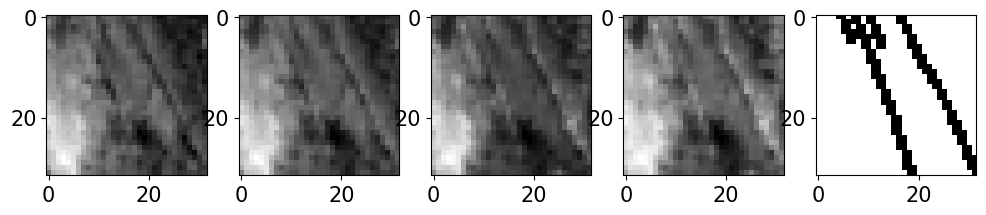

shape of augmented train data:  (22, 32, 32, 4)
shape of augmented label data:  (22, 32, 32, 1)
[0. 1.]


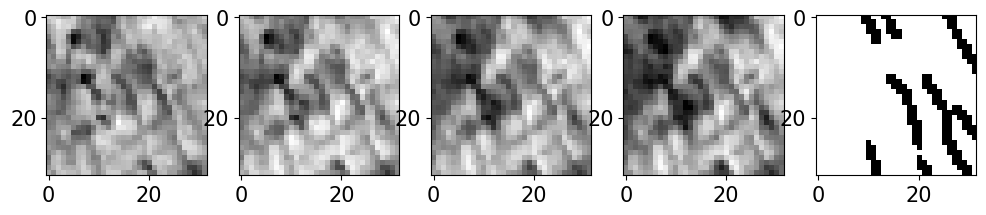

In [ ]:
#@title dataset preparation

#train/vali split, augmentation, sanity check - paths, variables, execusion

## variables

split_random_state = 2 # do not change!

study_area = "kalahari" #@param["kalahari", "simpson"]

test_size_number = 0.1 #@param{type: "number"}

#@markdown Which of the following datasets would you like to include?
sentinel = True #@param{type:"boolean"}
dem = False #@param{type:"boolean"}
curv = False #@param{type:"boolean"}
curv_smooth = False #@param{type:"boolean"}
dune_height = False #@param{type:"boolean"}

#@markdown Would you like to sample data down to 30m res?
conduct_downsampling = True #@param{type:"boolean"}

#@markdown Conduct augmentation?
conduct_augmentation = False #@param{type:"boolean"}

batch_size_aug = 4 #@param{type:"integer"}

#@markdown rotation range - turn off: 0
rotation_range = 0 #@param {type:"slider", min:0, max:360, step:1}
#@markdown width shift range - turn off: 0
width_shift_range = 0.0 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
#@markdown height shift range - turn off: 0
height_shift_range = 0.0 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

#@markdown zooms - turn off: both 1.0
zoom_in = 1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
zoom_out = 1 #@param {type:"slider", min:1.0, max:2.0, step:0.1}
zoom_range = [zoom_in, zoom_out]

horizontal_flip = True #@param{type:"boolean"}
vertical_flip = True #@param{type:"boolean"}

# #@markdown brightness_range - turn off: both 1.0
# brightness_range_low = 0.3 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
# brightness_range_high = 1.0 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
# brightness_range = [brightness_range_low, brightness_range_high]
brightness_range_decision = True #@param{type:"boolean"}
#brightness_range = (0.3, 1.0)
#brightness_range_values = [(0.3, 1.0), (0.3, 1.0), (0.3, 1.0), (0.3, 1.0)]

fill_mode = "constant" #@param["constant", "nearest", "reflect", "wrap"]

label_mask_threshold = 0.0 #@param{type:"slider", min:0.0, max:1.0, step:0.1}

#@markdown Save sanity check images?
sanity_check_save = False #@param{type:"boolean"}



## paths

LABELS_FOLDER_PATH = os.path.join(HOME_PATH, study_area, "pp_data", "train_pp", "labels")
TRAIN_FIG_FOLDER_PATH = os.path.join(HOME_PATH, "figures", date_today)
CSV_TRAIN_FILE_PATH = os.path.join(HOME_PATH, "csv", "train_images_info.csv")
CSV_VALI_FILE_PATH = os.path.join(HOME_PATH, "csv", "vali_images_info.csv")



## execution

# create list of datasets that will be included in training
list_paths_train_pp_img = create_training_dir_list(HOME_PATH,
                                                  study_area,
                                                  sentinel,
                                                  dem,
                                                  curv,
                                                  curv_smooth,
                                                  dune_height)

#print(list_paths_train_pp_img)

# gather data and split into training and validation
X_train, X_vali, y_train, y_vali = dataset_prep_split(list_paths_train_pp_img,
                                                      LABELS_FOLDER_PATH,
                                                      test_size_number,
                                                      split_random_state,
                                                      CSV_TRAIN_FILE_PATH,
                                                      CSV_VALI_FILE_PATH,
                                                      conduct_downsampling)

X_train_shape = X_train.shape
X_vali_shape = X_vali.shape

# augmentation
if conduct_augmentation:

  seed = 42 # do not change!!

  train_generator = augmentation(X_train,
                                 y_train,
                                 SEED,
                                 True,
                                 batch_size_aug,
                                 rotation_range,
                                 width_shift_range,
                                 height_shift_range,
                                 zoom_range,
                                 horizontal_flip,
                                 vertical_flip,
                                 brightness_range_decision,
                                 fill_mode,
                                 label_mask_threshold)



  vali_generator = augmentation(X_vali,
                                y_vali,
                                SEED,
                                False,
                                batch_size_aug,
                                rotation_range,
                                width_shift_range,
                                height_shift_range,
                                zoom_range,
                                horizontal_flip,
                                vertical_flip,
                                brightness_range_decision,
                                fill_mode,
                                label_mask_threshold)
  # ! vali_generator doesn't need augmentation settings if on False, but function needs it





# sanity check of training and validation data


if conduct_augmentation:

  sanity_check_yes_augmentation(train_generator, vali_generator, TRAIN_FIG_FOLDER_PATH, sanity_check_save)

else:
  train_generator = None
  vali_generator = None
  sanity_check_no_augmentation(X_train, y_train, X_vali, y_vali, TRAIN_FIG_FOLDER_PATH, sanity_check_save)

In [ ]:
#@title load model and train - paths, variables, execution

## variables

#@markdown batchsize - if not set in augmentation - check if same?
batch_size = 4 #@param{type:"integer"}

if conduct_augmentation:
  batch_size = batch_size_aug


model_type = "unet_large" #@param["unet_small", "unet_medium", "unet_large"]
epoch_nr = 150 #@param{type:"integer"}

learning_rate = "schedule" #@param[0.001, 0.0001, 0.00001, "schedule"]

loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=False)

prediction_threshold = 0.4 #@param{type:"slider", min:0.0, max:1.0, step:0.1}

metric = "tiou_metric" #@param["iou_metric", "binary_iou", "tiou_metric", "false_positive_metric"]
train_accuracy_metric = metric
val_accuracy_metric = f"val_{metric}"

activation_1 = "relu"
activation_2 = "sigmoid"

tile_size = 96 #@param{type:"integer"}
band_nr = 4 #@param{type:"integer"}


epoch_monitor = "val_tiou_metric" #@param["val_tiou_metric", "val_binary_iou", "val_loss"]
epoch_patience = 60 #@param{type:"integer"}

#warm-up epochs before early stopping starts
start_from_epoch = 1 #@param{type:"integer"}
early_stopping_mode = "max" #@param["auto", "min", "max"]
monitor_bestweight = "val_tiou_metric" #@param["val_tiou_metric", "val_binary_iou", "val_loss"]
mode_bestweight = "max" #@param["auto", "min", "max"]
shuffle = False #@param{type:"boolean"}

#@markdown Using finetuning (pre-trained model)?
load_pre_trained_weights = False #@param{type:"boolean"}
pre_trained_weights_filename = "best_model.keras"
#@markdown experiment of finetune model to use
finetune_experiment_id = "blabla" #@param{type:"boolean"}

wandb_project_name = "downsample-aug-hyperpar-2" #@param{type:"string"}



#@markdown Calculate 6 IoU types?
tiou_extended = False #@param{type:"boolean"}



########## LOOP ##########

lrs = [0.01, 0.001]
#bs = [2, 4, 8, 16, 32]
mts = ["unet_small", "unet_large"]
prth = [0.5]
mtr = ["binary_iou"]
epnr = [100, 150]



for initial_learning_rate, model_type, prediction_threshold, metric, epoch_nr in list(it.product(lrs, mts, prth, mtr, epnr)):

  if initial_learning_rate == 0.1:
    print("already done.")

  else:

    epoch_patience = epoch_nr

    if metric == "tiou_metric":
      epoch_monitor = "val_tiou_metric"
      monitor_bestweight = "val_tiou_metric"

    if metric == "binary_iou":
      epoch_monitor = "val_binary_iou"
      monitor_bestweight = "val_binary_iou"

    train_accuracy_metric = metric
    val_accuracy_metric = f"val_{metric}"

    date_time_today = datetime.now().strftime("%Y-%m-%d-%H-%M")

    ## generate random letters

    def generate_random_letters(length=4):
      letters = string.ascii_letters  # includes both lowercase and uppercase letters
      return ''.join(random.choice(letters) for _ in range(length))

    random_letters = generate_random_letters()

    ## learning rate scheduling
    if learning_rate == "schedule":

      num_steps = ((len(X_train) // batch_size) + 1) * epoch_nr
      warmup_ratio = 0.1
      warmup_target = None #0.001
      #initial_learning_rate = 0.001 #warmup_target * 0.01
      decay_steps = (1 - warmup_ratio) * num_steps
      warmup_steps = None #warmup_ratio * num_steps

      learning_rate_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps, alpha=0.0, warmup_steps=warmup_steps, warmup_target=warmup_target)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)


    ########## TRAINING ##########


    ## load model

    def get_model():
      if model_type == "unet_small":
        return unet_model_small(tile_size, tile_size, band_nr, SEED, optimizer, metric, prediction_threshold)
      elif model_type == "unet_medium":
        return unet_model_medium(tile_size, tile_size, band_nr, SEED, optimizer, metric, prediction_threshold)
      elif model_type == "unet_large":
        return unet_model_large(tile_size, tile_size, band_nr, SEED, optimizer, metric, prediction_threshold)


    ## wandb initialisation

    wandb.init(
        project=wandb_project_name,
        name=f"{date_time_today}_{wandb_project_name}_{random_letters}_duneminds_exp",
        config={
            "epochs": epoch_nr,
            "conduct_augmentation": conduct_augmentation,
            "batch_size_aug": batch_size_aug,
            "learning_rate": str(learning_rate),
            "X_train_shape": X_train_shape,
            "sentinel_used": sentinel,
            "dem_used": dem,
            "curv_used": curv,
            "curv_smooth_used": curv_smooth,
            "dune_height_used": dune_height,
            "rotation_range": rotation_range,
            "width_shift_range": width_shift_range,
            "height_shift_range": height_shift_range,
            "zoom_in": zoom_in,
            "zoom_out": zoom_out,
            "horizontal_flip": horizontal_flip,
            "vertical_flip": vertical_flip,
            "brightness_range_decision": brightness_range_decision,
            "fill_mode": fill_mode,
            "label_mask_threshold": label_mask_threshold,
            "batch_size": batch_size,
            "model_type": model_type,
            "optimizer": str(optimizer),
            "loss": str(loss),
            "metric": str(metric),
            "activation_1": activation_1,
            "activation_2": activation_2,
            "fine_tuning_decision": load_pre_trained_weights,
            "epoch_monitor": epoch_monitor,
            "epoch_patience": epoch_patience,
            "start_from_epoch": start_from_epoch,
            "early_stopping_mode": early_stopping_mode,
            "monitor_bestweight": monitor_bestweight,
            "prediction_threshold": prediction_threshold,
            "initial_learning_rate": initial_learning_rate,
            "learning_rate_schedule": str(learning_rate_schedule)
            }
        )


    ## paths

    EXPERIMENT_FOLDER_PATH = os.path.join(HOME_PATH, "experiments", f"{date_time_today}_{wandb_project_name}_{random_letters}_duneminds_exp")
    WEIGHTS_FOLDER_PATH = EXPERIMENT_FOLDER_PATH
    #weight_filename = f"{date_time_today}_{model_type}_weights.keras"
    #weight_filename_lastepoch = f"{date_time_today}_{model_type}_last_weights.keras"
    MODEL_FILES_FOLDER_PATH = EXPERIMENT_FOLDER_PATH
    model_filename = "best_model.keras"
    CONFIG_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, "config.json")
    HISTORY_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, "history.json")
    LOSS_FIGURE_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, "LOSS.png")
    ACC_FIGURE_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, "ACC.png")
    FINETUNE_MODEL_FOLDER_PATH = os.path.join(HOME_PATH, "experiments", finetune_experiment_id)


    model = get_model()


    ## training

    model, history = training_model(load_pre_trained_weights,
                    epoch_monitor,
                    epoch_patience,
                    start_from_epoch,
                    early_stopping_mode,
                    monitor_bestweight,
                    mode_bestweight,
                    conduct_augmentation,
                    model,
                    X_train,
                    y_train,
                    batch_size,
                    epoch_nr,
                    X_vali,
                    y_vali,
                    shuffle,
                    train_generator,
                    vali_generator,
                    MODEL_FILES_FOLDER_PATH,
                    FINETUNE_MODEL_FOLDER_PATH)


    ## saving config


    with open(CONFIG_FILE_PATH, "w") as fh:
      json.dump({
          "seed":SEED,
          "train_study_area": study_area,
          "split_random_state": split_random_state,
          "train_dataset_list": list_paths_train_pp_img,
          "X_train_shape": X_train_shape,
          "X_vali_shape": X_vali_shape,
          "sentinel_used": sentinel,
          "dem_used": dem,
          "curv_used": curv,
          "curv_smooth_used": curv_smooth,
          "dune_height_used": dune_height,
          "test_size_number": test_size_number,
          "conduct_augmentation": conduct_augmentation,
          "batch_size_aug": batch_size_aug,
          "rotation_range": rotation_range,
          "width_shift_range": width_shift_range,
          "height_shift_range": height_shift_range,
          "zoom_in": zoom_in,
          "zoom_out": zoom_out,
          "horizontal_flip": horizontal_flip,
          "vertical_flip": vertical_flip,
          "brightness_range_decision": brightness_range_decision,
          "fill_mode": fill_mode,
          "label_mask_threshold": label_mask_threshold,
          "train_tile_size": tile_size,
          "epoch_nr": epoch_nr,
          "shuffle": shuffle,
          "batch_size": batch_size,
          "model_type": model_type,
          "learning_rate": str(learning_rate),
          "optimizer": str(optimizer),
          "loss": str(loss),
          "metric": str(metric),
          "activation_1": activation_1,
          "activation_2": activation_2,
          "fine_tuning_decision": load_pre_trained_weights,
          "epoch_monitor": epoch_monitor,
          "epoch_patience": epoch_patience,
          "start_from_epoch": start_from_epoch,
          "early_stopping_mode": early_stopping_mode,
          "monitor_bestweight": monitor_bestweight,
          "prediction_threshold": prediction_threshold,
          "initial_learning_rate": initial_learning_rate,
          "learning_rate_schedule": str(learning_rate_schedule)
        },
        fh, indent=2, sort_keys=False
      )


    ## saving history

    with open(HISTORY_FILE_PATH, "w") as fh:
      json.dump(history.history, fh, indent=2, sort_keys=True)




    ########## EVALUATION ##########

    model.load_weights(os.path.join(MODEL_FILES_FOLDER_PATH, "best_model.keras"))


    iou4, iou5, iou6, tiou_list, num_epochs, best_epoch_loss, best_epoch_val_loss, best_epoch_acc, best_epoch_val_acc, average_precision, average_recall = evaluate_training(
                                                        model,
                                                        prediction_threshold,
                                                        X_vali,
                                                        y_vali,
                                                        history,
                                                        LOSS_FIGURE_FILE_PATH,
                                                        ACC_FIGURE_FILE_PATH,
                                                        tiou_extended,
                                                        train_accuracy_metric,
                                                        val_accuracy_metric)

    if tiou_extended:

      metrics = {
                  "iou/iou4": iou4,
                  "iou/iou5": iou5,
                  "iou/iou6": iou6,
                  "iou/tiou_1": tiou_list[0],
                  "iou/tiou_2": tiou_list[1],
                  "iou/tiou_3": tiou_list[2],
                  "iou/tiou_4": tiou_list[3],
                  "iou/tiou_5": tiou_list[4],
                  "iou/tiou_6": tiou_list[5],
                  "best_epoch_loss": best_epoch_loss,
                  "best_epoch_val_loss": best_epoch_val_loss,
                  "best_epoch_acc": best_epoch_acc,
                  "best_epoch_val_acc": best_epoch_val_acc,
                  "average_precision": average_precision,
                  "average_recall": average_recall,
                  }

    else:

      metrics = {
                "best_epoch_val_loss": best_epoch_val_loss,
                "iou/iou4": iou4,
                "iou/iou5": iou5,
                "iou/iou6": iou6,
                "iou/tiou_1": tiou_list[0],
                "best_epoch_loss": best_epoch_loss,
                "best_epoch_val_loss": best_epoch_val_loss,
                "best_epoch_acc": best_epoch_acc,
                "best_epoch_val_acc": best_epoch_val_acc,
                "average_precision": average_precision,
                "average_recall": average_recall,
                }


    wandb.log({**metrics})
    wandb.finish()



KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, None, None, 16], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")
Created folder.
steps per epoch:  6


#**VISUALISING VALIDATION DATA**

1/1 [==============================] - 0s 55ms/step
Folder exists.


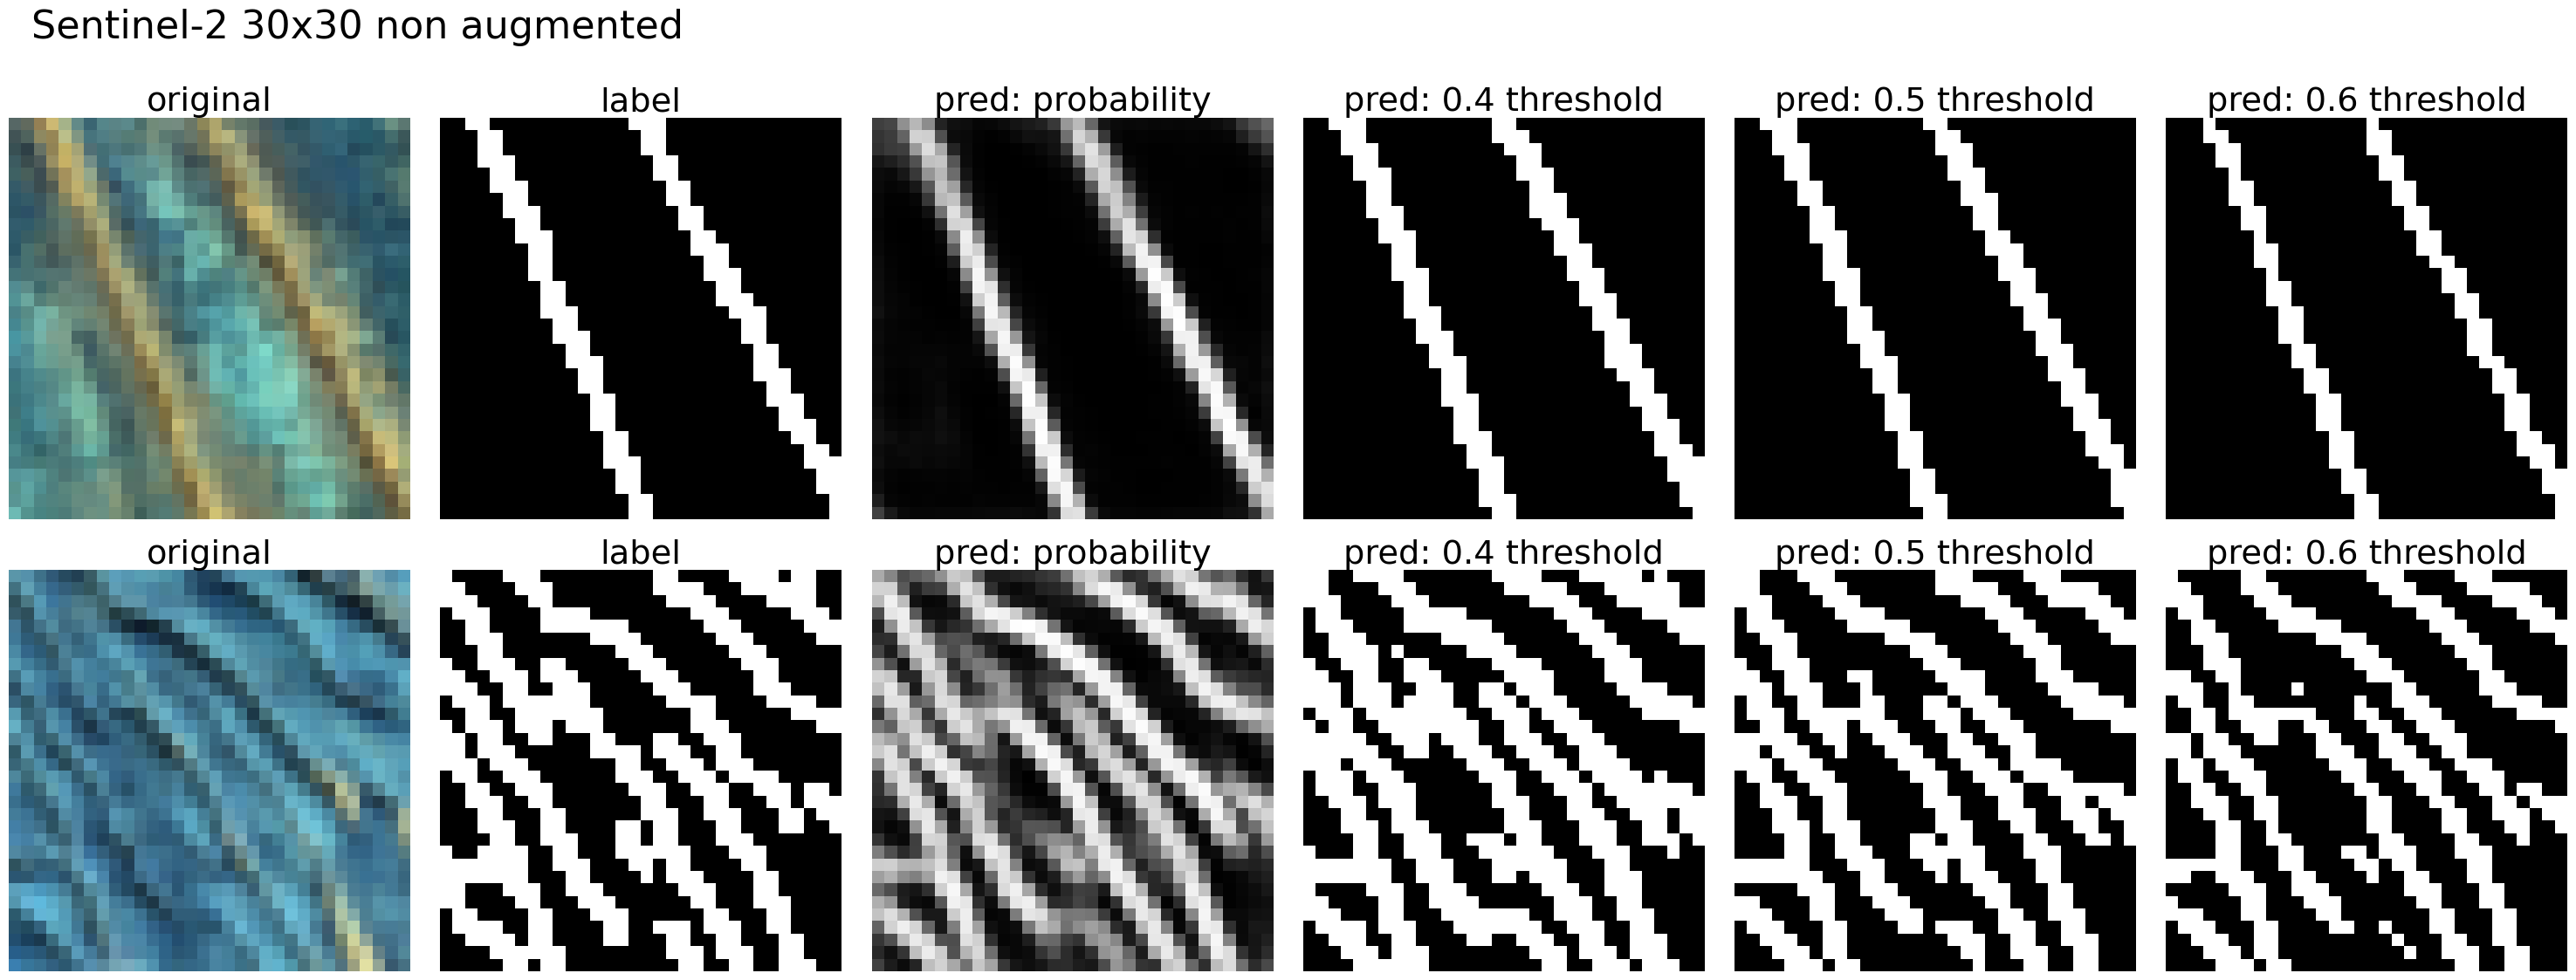

In [ ]:
#@title visualising validation results of multiple models

## variables

wandb_project_name = "downscale-hyperpar" #@param["downscale-hyperpar", "sentinel-hyperpar", "elevation-hyperpar", "mix-hyperpar"]
VALI_VIS_FIG_FOLDER_PATH = os.path.join(HOME_PATH, "experiments", wandb_project_name)

#@markdown Please determine thresholds and models directly in script.
list_thresholds = [0.4,
                   0.5,
                   0.6
                   ]
list_models = ["2024-04-09-17-05_downsample-hyperpar-2_OhbV_duneminds_exp",
              "2024-04-09-17-05_downsample-hyperpar-2_OhbV_duneminds_exp",
              "2024-04-09-17-05_downsample-hyperpar-2_OhbV_duneminds_exp"
              ]

chosen_imgs = [3, 8]

#(non) augmented
fig_title = "Sentinel-2 30x30 non augmented" #@param{type:"string"}

# Set the default fontsize for all figures
plt.rcParams.update({'font.size': 23})



## function for visualisation
def visualize_predictions(vali_img_array, vali_label_array, list_models, list_thresholds, vali_vis_fig_path, chosen_imgs, fig_title):
    #num_images = vali_img_array.shape[0]
    num_images = len(chosen_imgs)
    num_models = len(list_models)
    num_columns = num_models + 3


    fig, axes = plt.subplots(num_images, num_columns, figsize=(num_columns * 5, num_images * 6))
    fig.suptitle(fig_title, fontsize=32, x=0.02, ha='left')

    #for i in range(num_images):  # Go through all validation images
    for idx, i in enumerate(chosen_imgs):

        ## choose which ones to plot

        image = vali_img_array[i]
        img_r = image[:,:,2]
        img_g = image[:,:,1] #3 for mixes
        img_b = image[:,:,0]
        image_rgb = np.stack([img_r, img_g, img_b], axis=-1)
        axes[idx, 0].imshow(image_rgb)
        # axes[idx, 0].imshow(image)
        axes[idx, 0].set_title("original")
        axes[idx, 0].axis("off")


        # Plot the label
        cmap = mcolors.ListedColormap(['black', 'white']) #6e4731,#fbfbb7,#4492bb
        axes[idx, 1].imshow(vali_label_array[i], cmap=cmap)
        axes[idx, 1].set_title("label")
        axes[idx, 1].axis("off")

        for id, model_name in enumerate(list_models):  # Start from column index 2
            path_model = os.path.join(HOME_PATH, "experiments", model_name, "best_model.keras")
            model = tf.keras.models.load_model(path_model)

            probabilities = (model.predict(vali_img_array)[i, :, :, :])
            prediction = (model.predict(vali_img_array)[i, :, :, :] > list_thresholds[id]).astype(np.uint8)

            # save 0.4 threshold prediction
            if list_thresholds[id] == 0.5:
              final_prediction5 = prediction

            # Plot probability plot
            if id == 0:
              axes[idx, 2].imshow(probabilities.squeeze(), cmap="gray")
              axes[idx, 2].set_title(f"pred: probability")
              axes[idx, 2].axis("off")

            # plot prediction
            shift = id + 3
            axes[idx, shift].imshow(prediction.squeeze(), cmap="gray")
            axes[idx, shift].set_title(f"pred: {list_thresholds[id]} threshold")
            axes[idx, shift].axis("off")



    vali_vis_fig_file = f"vali_vis_{list_models[0]}_{list_thresholds[0]}-{list_thresholds[-1]}.png"
    fun_check_create_folder(vali_vis_fig_path)
    plt.tight_layout()
    plt.savefig(os.path.join(vali_vis_fig_path, vali_vis_fig_file))

    plt.show()
    plt.close()

    return final_prediction5


## execute function
final_prediction5 = visualize_predictions(X_vali, y_vali, list_models, list_thresholds, VALI_VIS_FIG_FOLDER_PATH, chosen_imgs, fig_title)


(32, 32, 1)
(32, 32, 1)
(32, 32, 1)


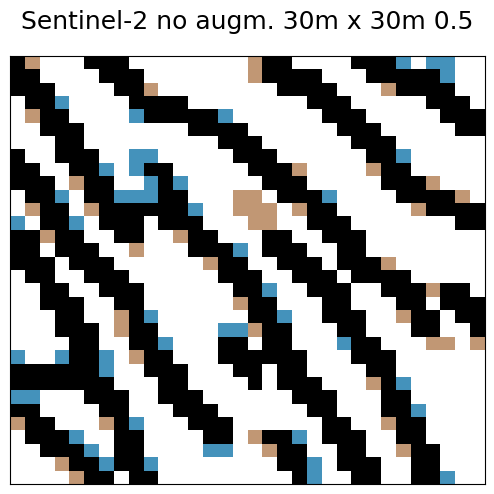

In [ ]:
#@title plot difference between label and prediction


label = y_vali[8]
prediction = final_prediction5

title_fig = "Sentinel-2 no augm. 30m x 30m 0.5" #@param{type:"string"}


print(label.shape)
print(prediction.shape)

# Set the default fontsize for all figures
plt.rcParams.update({'font.size': 15})


# Initialize result array with zeros
result = np.zeros_like(label)

# Find where both label and prediction have 1s
both_ones = (label == 1) & (prediction == 1)

# Find where only label has 1s
only_label = (label == 1) & (prediction == 0)

# Find where only prediction has 1s
only_pred = (label == 0) & (prediction == 1)

# Assign values based on the conditions
result[both_ones] = 3 #both
result[only_label] = 1 # only labels
result[only_pred] = 2 # only prediction

# Create result_all based on result array
result_all = np.zeros(result.shape, dtype=int)

# Map values from result to result_all

result_all[result == 1] = 1
result_all[result == 2] = 2
result_all[result == 3] = 3

print(result_all.shape)


## Plotting

# Define custom colors
colors = ["white", '#4492bb', '#c19774', "black"]

# Create a custom colormap with three colors
cmap_custom = ListedColormap(colors)

# Plotting with seaborn and matplotlib
plt.figure(figsize=(6, 6))
ax = sns.heatmap(result_all.squeeze(), cmap=cmap_custom, cbar=False)
#ax = sns.heatmap(prediction.squeeze(), cmap=cmap_custom, cbar=False)
plt.title(title_fig, pad=20)

# Add a frame around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')  # Set the color of the frame

# Remove x-axis and y-axis ticks and labels
plt.xticks([])
plt.yticks([])

plt.tight_layout(pad=3.0)  # Increase the pad value as needed

plt.show()



#**TESTING / PREDICTION**

In [ ]:
#@title SIMPLE prediction functions

'''
To be used when training/prediction are only based on one data set (e.g. only Sentinel-2 data or only COP-DEM data)
'''



def prediction(path_config, seed, path_model, path_overall_results, path_results, tile_size_test, prediction_threshold, path_test_img, train_id, input_tile_name, downsampling):

  ########## LOAD MODEL AND WEIGHTS ##########

  model = tf.keras.models.load_model(path_model)


  ########## PREPARE DATA ##########


  # create tile name for exporting
  output_tile_name = f"res_{input_tile_name}" # choose first list (0), file names should be the same across all lists

  if not downsampling:

    with rasterio.open(path_test_img) as src:
      img = src.read()
      crs = src.crs
      transform = src.transform

    img = np.transpose(img, (1,2,0))
    img = np.expand_dims(img, axis=0)

    width = tile_size_test
    height = tile_size_test



  elif downsampling:

    with rasterio.open(path_test_img, "r") as src:
      img_old = src.read()
      crs = src.crs
      #transform = src.transform
      profile = src.profile
      height = src.height // 3
      width = src.width // 3
      tile_size_test = height

      #downscaling
      img = src.read(
          out_shape=(src.count, height, width),
          resampling=Resampling.bilinear
      )

      transform = src.transform * src.transform.scale(
          (src.width // img.shape[-1]),
          (src.height // img.shape[-2])
      )
      print(f"transform: {transform}")

      profile.update(width=width, height=height, transform=transform)
      print(f"profile {profile}")


      img = np.transpose(img, (1,2,0))
      img = np.expand_dims(img, axis=0)




  ########## PREDICTION ##########


  ## check if there is a folder for result files
  fun_check_create_folder(path_overall_results)
  fun_check_create_folder(path_results)

  ## create prediction & save as geotiffs
  # print(test_dataset.shape)
  # for i in range(test_dataset.shape[0]): # go through required tiles & predict
  prediction_raw = model.predict(img)
  prediction = (model.predict(img) > prediction_threshold).astype(np.uint8)
  print('Prediction done for tile')
  print(prediction.shape)


  prediction_squeezed = np.squeeze(prediction, axis=0)

  prediction_reduced = prediction_squeezed.transpose((2,0,1))

  print(prediction_reduced.shape)



  # exporting - save prediction as geotiff
  with rasterio.open(os.path.join(path_results, output_tile_name),
                  'w',
                  driver='Gtiff',
                  width=width,
                  height=height,
                  count=1,
                  crs=crs,
                  transform=transform,
                  dtype='uint8' #used to be 'float32'
                  ) as test_img_result:

      # prediction_reduced = prediction_reduced.astype('uint8') # might compress data further?

    test_img_result.write(prediction_reduced)

  return prediction_raw

In [ ]:
#@title FUSION prediction functions

'''
To be used when training/prediction are based on multiple data sets (e.g. only Sentinel-2 + COP-DEM data)
'''



########## create list of folders that will be part of training / validation data ##########

def create_test_dir_list(home_dir,
                        study_area_train,
                        include_sentinel,
                        include_dem,
                        include_curv,
                        include_curv_smooth,
                        include_dune_height,
                        tile_size):

  selected_parameters = []
  list_paths_train_pp_img = []

  parameters = {
      "sentinel": include_sentinel,
      "dem": include_dem,
      "curv": include_curv,
      "curv_smooth": include_curv_smooth,
      "dune_height": include_dune_height
  }

  print(include_dem)

  for input_param, value in parameters.items():
    if value:
      selected_parameters.append(input_param)

  print(selected_parameters)

  if len(selected_parameters) > 4:
    sys.exit("Too many input data parameters selected. Cannot choose more than 4.")

  list_paths_train_pp_img = []
  for item in selected_parameters:
    paths_train_pp_img = os.path.join(home_dir, study_area_train, "pp_data", "test_pp", f"tiles_{tile_size}", item) # LIST of paths
    list_paths_train_pp_img.append(paths_train_pp_img)

  return list_paths_train_pp_img



def prediction_fusion(path_config,
                      seed,
                      path_model,
                      path_overall_results,
                      path_results,
                      tile_size_test,
                      prediction_threshold,
                      input_array,
                      train_id,
                      input_tile_name,
                      downsampling,
                      crs,
                      transform):

  ########## LOAD MODEL AND WEIGHTS ##########

  model = tf.keras.models.load_model(path_model)


  ########## PREPARE DATA ##########

  if not downsampling:
    # create tile name for exporting
    output_tile_name = f"res_fusion_{input_tile_name}" # choose first list (0), file names should be the same across all lists

    img = input_array
    img = np.expand_dims(img, axis=0)

  elif downsampling:
    print("To Do: Downsampling")


  ########## PREDICTION ##########


  ## check if there is a folder for result files
  fun_check_create_folder(path_overall_results)
  fun_check_create_folder(path_results)

  ## create prediction & save as geotiffs
  # print(test_dataset.shape)
  # for i in range(test_dataset.shape[0]): # go through required tiles & predict
  prediction_raw = model.predict(img)
  prediction = (model.predict(img) > prediction_threshold).astype(np.uint8)
  print('Prediction done for tile')
  print(prediction.shape)


  prediction_squeezed = np.squeeze(prediction, axis=0)

  prediction_reduced = prediction_squeezed.transpose((2,0,1))

  print(prediction_reduced.shape)



  # exporting - save prediction as geotiff
  with rasterio.open(os.path.join(path_results, output_tile_name),
                  'w',
                  driver='Gtiff',
                  width=tile_size_test,
                  height=tile_size_test,
                  count=1,
                  crs=crs,
                  transform=transform,
                  dtype='uint8' #used to be 'float32'
                  ) as test_img_result:

      # prediction_reduced = prediction_reduced.astype('uint8') # might compress data further?

    test_img_result.write(prediction_reduced)

  return prediction_raw

In [ ]:
#@title test/prediction - variables & execution

#path_results_run, path_results, path_weights, weight_file, model, path_config, path_test_pp


########## variables ##########

# working: kalahari_tile_sentinel_9600_14400_img.tif
# not working: kalahari_tile_sentinel_14400_19200_img.tif

# mix dem no aug: 2024-04-09-08-35_mix-hyperpar-2_OhbV_duneminds_exp

# non-downsampled: 2024-03-29-08-47_sentinel-hyperpar-2_OhbV_duneminds_exp
# downsampled: 2024-04-09-17-05_downsample-hyperpar-2_OhbV_duneminds_exp

train_id = "2024-04-09-08-35_mix-hyperpar-2_OhbV_duneminds_exp" #@param{type:"string"}
#input_tile_name = "kalahari_tile_sentinel_14400_19200_img.tif" #@param{type:"string"}
#model_type_train = "unet_large" #@param["unet_small", "unet_medium", "unet_large"]
study_area_test = "kalahari" #@param["kalahari", "simpson"]
tile_size_test_data = 4800 #@param{type:"integer"}
data_type = "fusion" #@param["fusion", "sentinel", "dem", "curv", "curv_smooth", "dune_height"]
sentinel = True #@param{type:"boolean"}
dem = True #@param{type:"boolean"}
curv = False #@param{type:"boolean"}
curv_smooth = False #@param{type:"boolean"}
dune_height = False #@param{type:"boolean"}
prediction_threshold = 0.4 #@param{type:"number"}
downsampling = False #@param{type: "boolean"}




########## paths ##########

EXPERIMENT_FOLDER_PATH = os.path.join(HOME_PATH, "experiments", f"{train_id}")

CONFIG_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, f"config.json")
TEST_FOLDER_PATH = os.path.join(HOME_PATH, study_area_test, "pp_data", "test_pp", f"tiles_{tile_size_test_data}", data_type)
MODEL_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, f"best_model.keras")
OVERALL_RESULTS_FOLDER_PATH = os.path.join(HOME_PATH, "results", "final_pred_maps", f"{study_area_test}_{data_type}_{tile_size_test_data}")
RESULTS_FOLDER_PATH = os.path.join(OVERALL_RESULTS_FOLDER_PATH, train_id)

test_dir_list = create_test_dir_list(HOME_PATH,
                                    study_area_test,
                                    sentinel,
                                    dem,
                                    curv,
                                    curv_smooth,
                                    dune_height,
                                    tile_size_test_data)

print(test_dir_list)


if len(test_dir_list) >= 2:
  test_data, test_data_info = fun_concatenate_img(test_dir_list)
  print(test_data.shape)

  for i in range(test_data.shape[0]):
    test_array = test_data[i,:,:,:]
    print(f"test array shape: {test_array.shape}")
    print(test_data_info)
    input_tile_name = test_data_info[i][1] #1: which image, 2: 1 path or 2 img name
    input_tile_path = os.path.join(test_data_info[i][0], input_tile_name)

    with rasterio.open(input_tile_path) as src:
      crs = src.crs
      transform = src.transform

    print(f"tile name: {input_tile_name}")

    prediction_array = prediction_fusion(CONFIG_FILE_PATH,
                                  SEED,
                                  MODEL_FILE_PATH,
                                  OVERALL_RESULTS_FOLDER_PATH,
                                  RESULTS_FOLDER_PATH,
                                  tile_size_test_data,
                                  prediction_threshold,
                                  test_array,
                                  train_id,
                                  input_tile_name,
                                  downsampling,
                                  crs,
                                  transform)



elif len(test_dir_list) == 0:
  sys.exit("No data chosen.")

else:

  for file in sorted(os.listdir(test_dir_list[0])):
    if file.endswith('.tif'):
      print(file)
      input_tile_name = file
      path_test_img = os.path.join(test_dir_list[0], input_tile_name)

      prediction_array = prediction(CONFIG_FILE_PATH,
                                    SEED,
                                    MODEL_FILE_PATH,
                                    OVERALL_RESULTS_FOLDER_PATH,
                                    RESULTS_FOLDER_PATH,
                                    tile_size_test_data,
                                    prediction_threshold,
                                    path_test_img,
                                    train_id,
                                    input_tile_name,
                                    downsampling)

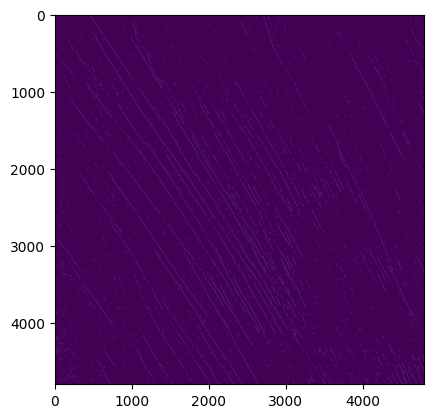

In [ ]:
prediction_array = prediction_array.squeeze(axis=0)
plt.imshow(prediction_array)
plt.show()